In [1]:
# Imports
%load_ext autoreload
%autoreload 2
#%matplotlib ipympl
#%matplotlib widget
import pathlib
import sys
import random
sys.path.append('../')
sys.path.append('/usr/users/kcohrs/bayesian-q10/ONEFlux/')

import torch
import torch.utils.data
import torchvision.utils
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset

import numpy as np
import math

import fastprogress
import matplotlib.pyplot as plt
import scipy.stats as stats

import pandas as pd
import shutil
from sklearn.metrics import r2_score

from bayesian_q10.experiments import experiment, experiment_utils
from bayesian_q10.analysis.visualization import *
from bayesian_q10.datasets.preprocessing import * 

In [ ]:
data.pd

In [744]:
exp.data['site'] = 'FI-Hyy'
monthly_curves(exp.data, site='FI-Hyy', year=2015, res=False, flux='RECO')

In [1034]:
path = '/usr/users/kcohrs/bayesian-q10/exp/FPDML_all_2022-07-07_4/'
data=pd.read_csv(path + 'results_all.csv')
#data=pd.read_csv('/usr/users/kcohrs/bayesian-q10/exp/FPDML_all_2022-07-05_1/results_all.csv')
fileObject = open(path + "experiment_config.txt", "r")
file = fileObject.read()
print(file)

{"experiment_type": "flux_partitioning", "comment": "Syntehtic data at different noise levels: level 2.0.", "extrapolate": false, "seed": 1000, "dataset_config": "dataset_config65.txt", "model_config": "model_config65.txt"}


In [1035]:
print(data.round(3).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} & Unnamed: 0 &  R2\_med &   R2\_25 &   R2\_75 &  MSE\_med &   MSE\_25 &   MSE\_75 \\
\midrule
0 &       RECO &   0.155 &  -0.219 &   0.397 &    8.096 &    5.288 &   12.906 \\
1 &   RECO\_res & -12.452 & -14.109 & -10.925 &  128.124 &  110.999 &  161.270 \\
2 &        GPP &   0.677 &   0.579 &   0.770 &   10.377 &    7.798 &   17.135 \\
3 &        NEE &   0.255 &   0.233 &   0.278 &  122.845 &  106.859 &  150.536 \\
4 &  NEE\_clean &   0.869 &   0.848 &   0.885 &    0.869 &    0.848 &    0.885 \\
\bottomrule
\end{tabular}



In [186]:
exp.data

TIMESTAMP_START  TIMESTAMP_END  TA_F_MDS  TA_F_MDS_QC  TA_ERA   TA_F  \
333120     201501010000   201501010030     3.440            0   3.006  3.440   
333121     201501010030   201501010100     3.310            0   3.009  3.310   
333122     201501010100   201501010130     3.310            0   3.012  3.310   
333123     201501010130   201501010200     3.420            0   3.134  3.420   
333124     201501010200   201501010230     3.460            0   3.256  3.460   
...                 ...            ...       ...          ...     ...    ...   
350635     201512312130   201512312200    -2.993            3  -3.362 -3.362   
350636     201512312200   201512312230    -2.984            3  -3.663 -3.663   
350637     201512312230   201512312300    -2.976            3  -3.799 -3.799   
350638     201512312300   201512312330    -2.968            3  -3.935 -3.935   
350639     201512312330   201601010000    -2.960            3  -4.087 -4.087   

        TA_F_QC  SW_IN_POT  SW_IN_F_MDS  SW_IN_F_MDS_QC  ...         T  \
333120        0        0.0         0.00               0  ...  0.000000   
333121        0        0.0         0.00               0  ...  0.000000   
333122        0        0.0         0.00               0  ...  0.000000   
333123        0        0.0         0.00               0  ...  0.000000   
333124        0        0.0         0.00               0  ...  0.000000   
...         ...        ...          ...             ...  ...       ...   
350635        2        0.0         0.03               0  ...  0.001081   
350636        2        0.0         0.49               0  ...  0.017577   
350637        2        0.0         0.64               0  ...  0.022925   
350638        2        0.0         0.00               0  ...  0.000000   
350639        2        0.0         0.00               0  ...  0.000000   

        GPP_orth  RECO_orth  RECO_orth_res  NEE_orth    T_orth  LUE_orth  \
333120  0.000000   0.341004       0.316508  0.341004  0.010604  0.850151   
333121  0.000000   0.321064       0.314081  0.321064  0.006486  0.750795   
333122  0.000000   0.325711       0.313239  0.325711  0.012260  0.750795   
333123  0.000000   0.325711       0.311679  0.325711  0.012260  0.750795   
333124  0.000000   0.321377       0.308130  0.321377  0.006486  0.750795   
...          ...        ...            ...       ...       ...       ...   
350635  0.000491   0.347942       0.210037  0.347451  0.007312  0.454605   
350636  0.007991   0.398775       0.707278  0.390784  0.009768  0.454605   
350637  0.010422   0.407458      -0.278985  0.397037  0.009768  0.454605   
350638  0.000000   0.414492      -0.016713  0.414492  0.025239  0.454605   
350639  0.000000   0.454189       0.609139  0.454189  0.033465  0.454605   

          site    NEE_DT    NEE_NT  
333120  FI-Hyy  0.302069  0.316508  
333121  FI-Hyy  0.298550  0.314081  
333122  FI-Hyy  0.298550  0.313239  
333123  FI-Hyy  0.301527  0.311679  
333124  FI-Hyy  0.302613  0.308130  
...        ...       ...       ...  
350635  FI-Hyy  0.229029  0.209546  
350636  FI-Hyy  0.219752  0.699287  
350637  FI-Hyy  0.215643 -0.289408  
350638  FI-Hyy  0.211585 -0.016713  
350639  FI-Hyy  0.207110  0.609139  

[17520 rows x 300 columns]

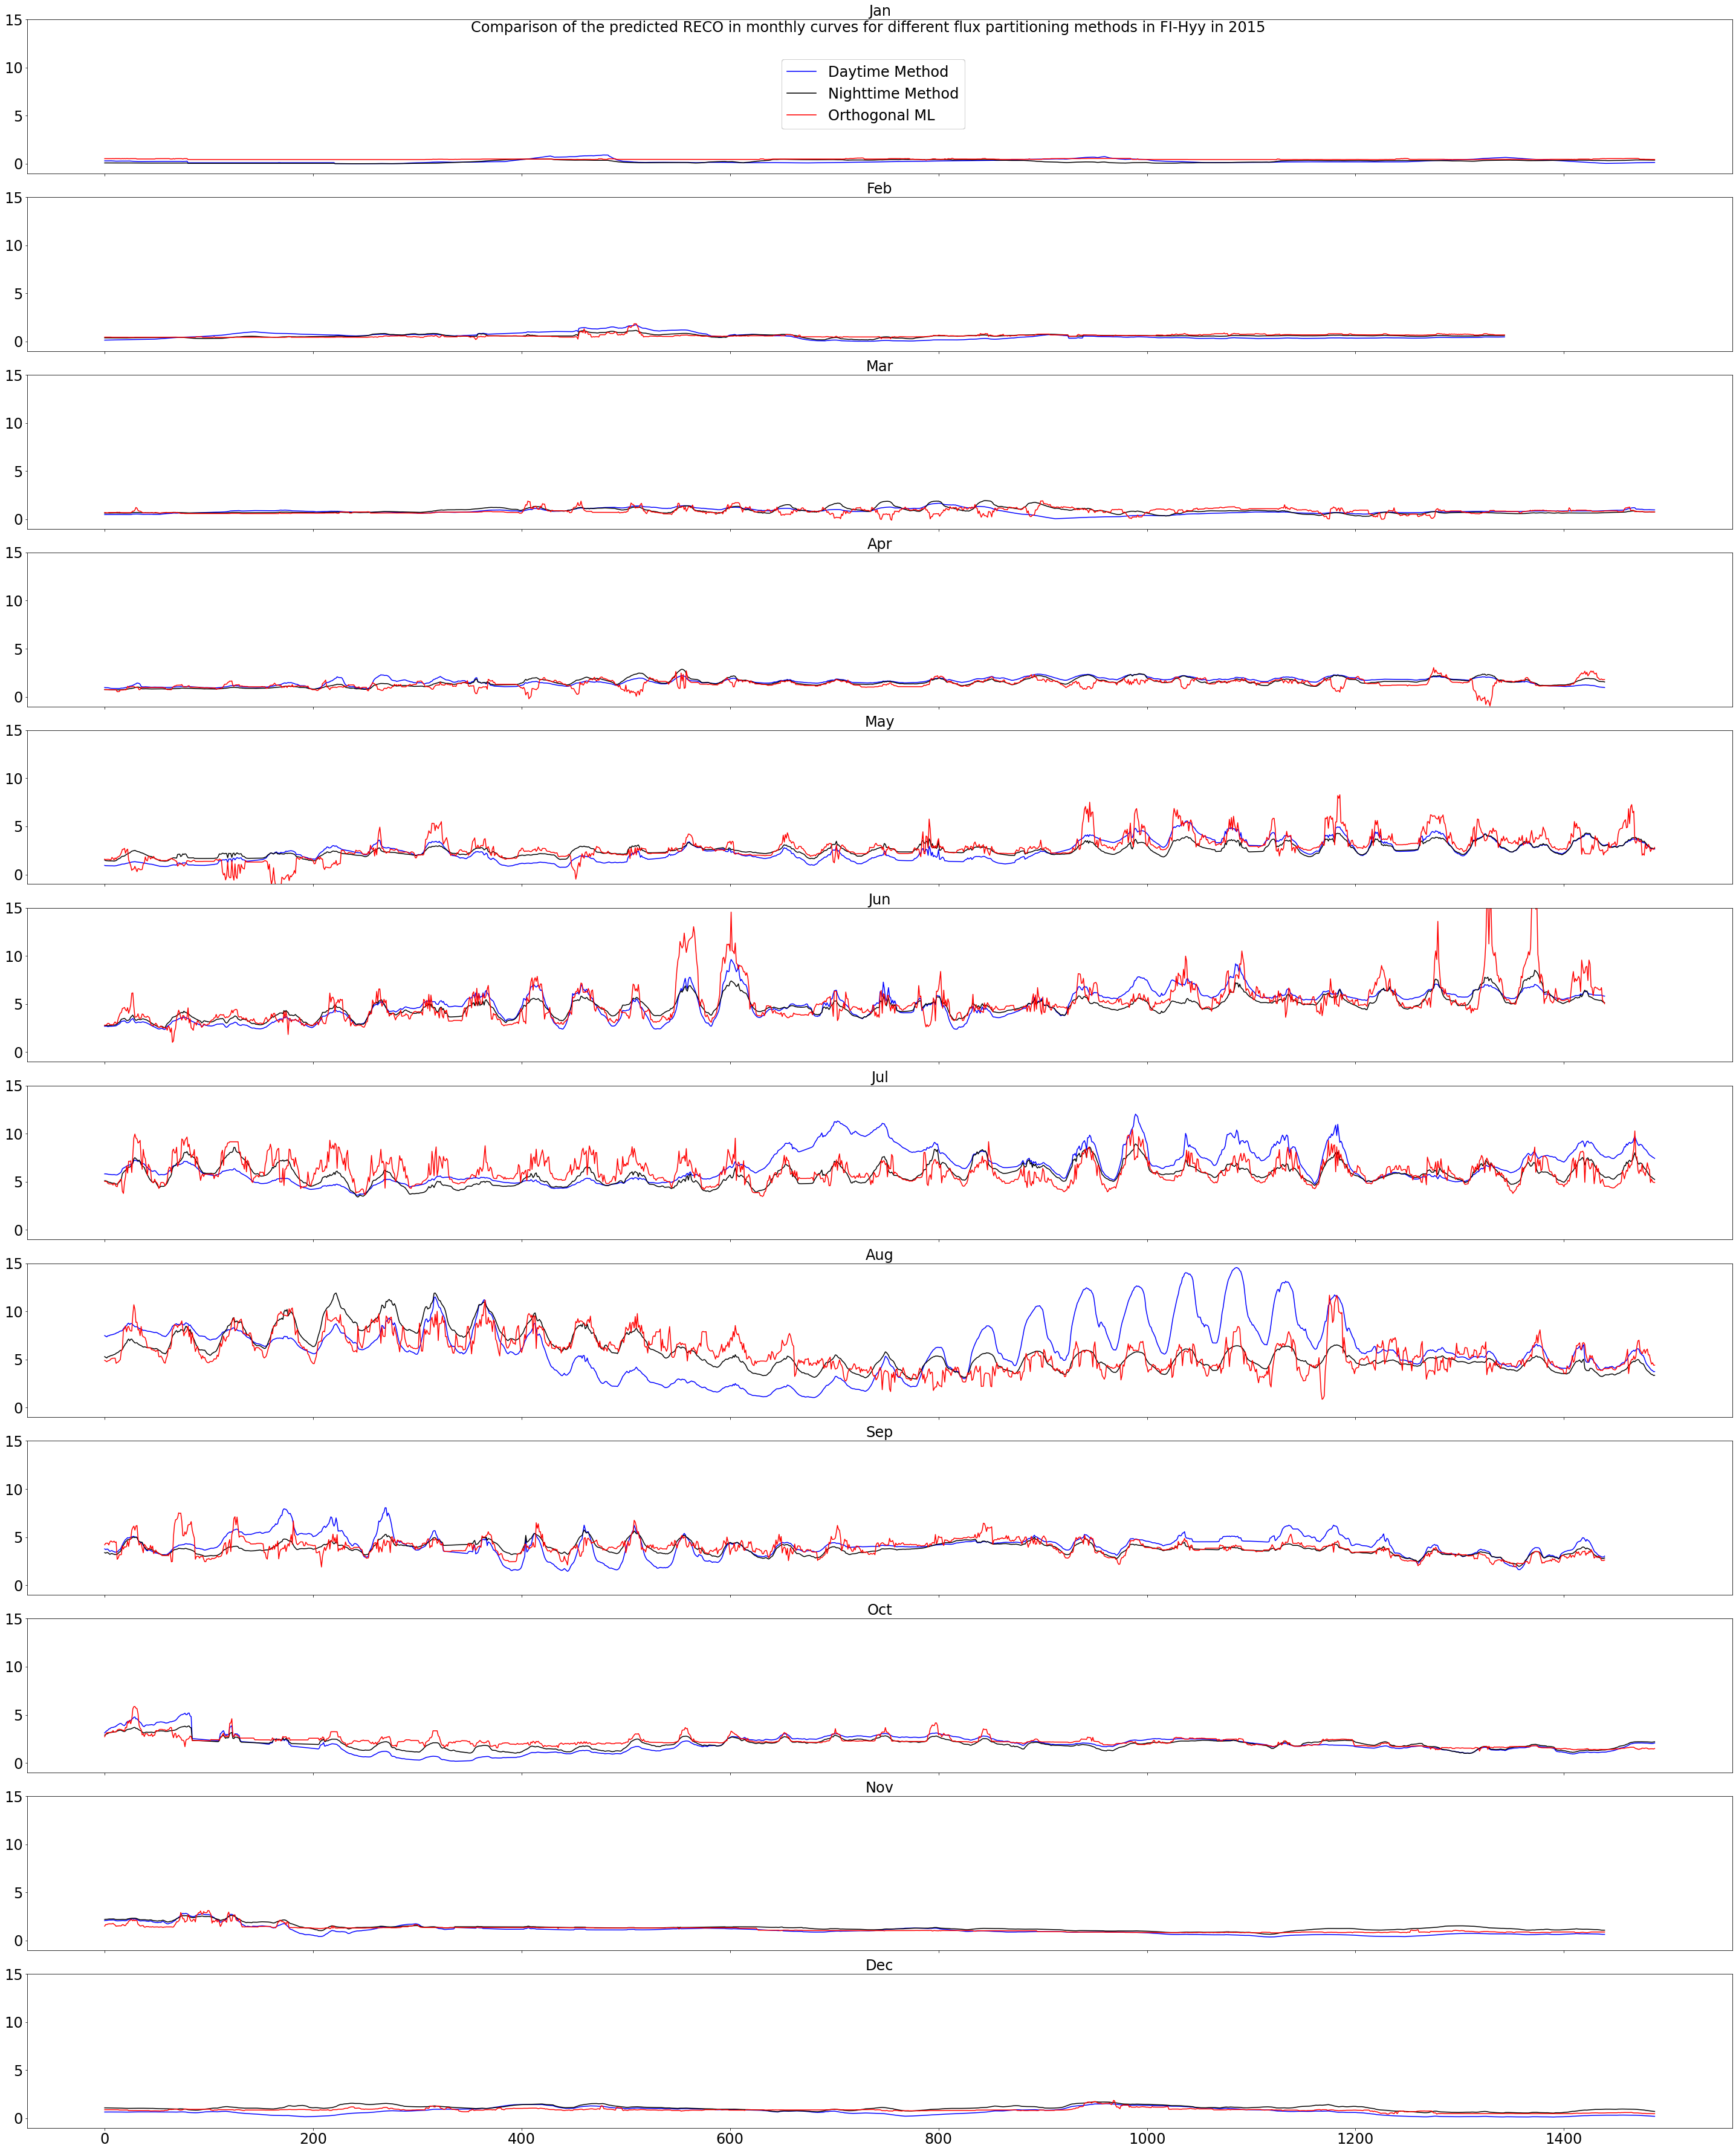

In [892]:
monthly_curves(data, site='FI-Hyy', year=2015, res=False, flux='RECO', path='/usr/users/kcohrs/bayesian-q10/exp/FPDML_all_2022-07-05_1')

In [ ]:
monthly_curves(exp4.data, site='FI-Hyy', year=2015, res=False, flux='RECO')

In [954]:
data.drop((np.arange(len(data))[(data['Year']==data['Year'].min())]), axis=0)['Year'].min()

1997

In [181]:
exp.dml.est.__dict__

{'model_y': GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                           min_samples_leaf=10, min_samples_split=10),
 'model_t': GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                           min_samples_leaf=10, min_samples_split=10),
 'featurizer': None,
 'model_final': GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                           min_samples_leaf=10, min_samples_split=10),
 'cv': 2,
 'discrete_treatment': False,
 'discrete_instrument': False,
 'random_state': None,
 'categories': 'auto',
 'mc_iters': None,
 'mc_agg': 'mean',
 '_ortho_learner_model_final': <econml.dml._rlearner._ModelFinal at 0x7f3f1c5dd250>,
 '_ortho_learner_model_nuisance': <econml.dml._rlearner._ModelNuisance at 0x7f3f1c5dd0d0>,
 '_d_y': (),
 '_d_t': (),
 '_input_names': {'feature_names': ['VPD_n',
   'TA_n',
   'SW_POT_sm_n',
   'wdefcum_n',
   'SW_POT_sm_diff_n'],
  'output_names': ['NEE'],
  'treatment_names': ['T']},
 '_d_t_in': (

In [ ]:
evaluate(data, syn=False)

In [670]:
evaluate(exp.data, syn=Falbse)

(   Year      RECO  RECO_res       GPP       NEE QC method
 0  2015  0.715350  0.611666  0.912451  0.893545  2     DT
 1  2015  0.819906  0.658807  0.951849  0.950852  2     NT
 2  2015  0.823973  0.823973  0.898086  0.852282  2   DTNT
 3  2016  0.732452  0.566889  0.857173  0.798504  0     DT
 4  2016  0.759280  0.512953  0.930871  0.929168  0     NT
 5  2016  0.828860  0.828860  0.816374  0.733426  0   DTNT,
    Year      RECO  RECO_res       GPP       NEE QC method
 0  2015  1.785956  2.436491  2.642115  1.906685  2     DT
 1  2015  0.786477  1.490000  1.490000  0.978306  2     NT
 2  2015  1.104428  1.104428  3.075611  2.645736  2   DTNT
 3  2016  1.681792  2.722507  4.140243  3.536340  0     DT
 4  2016  1.047219  2.118836  2.118837  1.469413  0     NT
 5  2016  1.075772  1.075772  5.322918  4.678484  0   DTNT,
 {'DT':             R2_med     R2_25     R2_75   MSE_med    MSE_25    MSE_75
  RECO      0.723901  0.719625  0.728176  1.733874  1.707833  1.759915
  RECO_res  0.589278  0.

In [407]:
for var in exp.data.columns:
    print(var)

TIMESTAMP_START
TIMESTAMP_END
TA_F_MDS
TA_F_MDS_QC
TA_ERA
TA_F
TA_F_QC
SW_IN_POT
SW_IN_F_MDS
SW_IN_F_MDS_QC
SW_IN_ERA
SW_IN_F
SW_IN_F_QC
LW_IN_F_MDS
LW_IN_F_MDS_QC
LW_IN_ERA
LW_IN_F
LW_IN_F_QC
LW_IN_JSB
LW_IN_JSB_QC
LW_IN_JSB_ERA
LW_IN_JSB_F
LW_IN_JSB_F_QC
VPD_F_MDS
VPD_F_MDS_QC
VPD_ERA
VPD_F
VPD_F_QC
PA
PA_ERA
PA_F
PA_F_QC
P
P_ERA
P_F
P_F_QC
WS
WS_ERA
WS_F
WS_F_QC
WD
USTAR
RH
NETRAD
PPFD_IN
PPFD_DIF
PPFD_OUT
SW_DIF
SW_OUT
LW_OUT
CO2_F_MDS
CO2_F_MDS_QC
TS_F_MDS_1
TS_F_MDS_2
TS_F_MDS_3
TS_F_MDS_4
TS_F_MDS_5
TS_F_MDS_1_QC
TS_F_MDS_2_QC
TS_F_MDS_3_QC
TS_F_MDS_4_QC
TS_F_MDS_5_QC
SWC_F_MDS_1
SWC_F_MDS_2
SWC_F_MDS_3
SWC_F_MDS_4
SWC_F_MDS_5
SWC_F_MDS_1_QC
SWC_F_MDS_2_QC
SWC_F_MDS_3_QC
SWC_F_MDS_4_QC
SWC_F_MDS_5_QC
G_F_MDS
G_F_MDS_QC
LE_F_MDS
LE_F_MDS_QC
LE_CORR
LE_CORR_25
LE_CORR_75
LE_RANDUNC
LE_RANDUNC_METHOD
LE_RANDUNC_N
LE_CORR_JOINTUNC
H_F_MDS
H_F_MDS_QC
H_CORR
H_CORR_25
H_CORR_75
H_RANDUNC
H_RANDUNC_METHOD
H_RANDUNC_N
H_CORR_JOINTUNC
EBC_CF_N
EBC_CF_METHOD
NIGHT
NEE_CUT_REF
NEE_VUT_REF


In [424]:
np.sin(exp.data['WD']/180*np.pi), np.cos(exp.data['WD']/180*np.pi)

(333120   -0.962833
 333121   -0.985996
 333122   -0.988573
 333123   -0.983287
 333124   -0.979010
             ...   
 350635    0.535385
 350636    0.612493
 350637    0.489230
 350638    0.378649
 350639    0.462213
 Name: WD, Length: 17520, dtype: float64,
 333120    0.270096
 333121    0.166769
 333122    0.150743
 333123    0.182064
 333124    0.203813
             ...   
 350635   -0.844608
 350636   -0.790476
 350637   -0.872155
 350638   -0.925541
 350639   -0.886769
 Name: WD, Length: 17520, dtype: float64)

In [488]:
dataset_config = dict(
                site_name = "FI-Hyy",
                syn = False,
                Q10=1.5,
                relnoise=0.1,
                transform_T = True,
                month_wise= True,
                delta = 'heuristic3', #fixed value, max_heuristic, slope_heuristic 
                X = ['VPD', 'TA','wdefcum', 'SW_POT_sm', 'SW_POT_sm_diff'],
                #X = ['VPD', 'TA','wdefcum', 'SW_POT_sm', 'SW_POT_sm_diff', 'PA', 'WS', 'GPP_prox', 'P', 'WD_sin', 'WD_cos', 'NEE_nt_avg', 'TS_1', 'TS_2', 'SWC_1', 'SWC_2'], #['VPD', 'TA'],#
                W = [], #['SW_POT_sm', 'SW_POT_sm_diff'], #['wdefcum'],
                years = [2015], #'all'
                norm_type = 'standardize'
                )

model_y_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = 50,
                      min_samples_leaf = 50,
                      #n_estimators=150,
                     #learning_rate=0.1,
                     #max_depth=3
                     )
model_t_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = 50,
                      min_samples_leaf = 50,
                     #n_estimators=150,
                     #learning_rate=0.1,
                     # max_depth=3
                     )
model_final_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = 15,
                      min_samples_leaf = 15)
dml_config = dict(cv=30)

model_configs = dict(y = model_y_config,
                    t = model_t_config,
                    final= model_final_config,
                    dml =dml_config)

experiment_config = dict(experiment_type = "flux_partitioning",
                         comment=f'All sites, with extrapolation',
                         extrapolate=False,
                         seed=1000)

In [ ]:
#import shutil, itertools
a = [50]
b = [50]
c = [500]
d = [5]
e = [1]
loss='ls'

for min_samples_split, min_samples_leaf, n_estimators, cv, max_depth in list(itertools.product(a, b, c, d, e)):
    model_y_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = min_samples_split,
                      min_samples_leaf = min_samples_leaf,
                      max_depth = max_depth,
                      n_estimators=n_estimators,
                      loss=loss,
                      max_features=5,
                      )
    
    model_t_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = min_samples_split,
                      min_samples_leaf = min_samples_leaf,
                      max_depth = max_depth,
                      n_estimators=n_estimators,
                      loss=loss,
                      max_features=5,
                      )
    
    #model_y_config = dict(model = 'MLPRegressor')
    #model_t_config = dict(model = 'MLPRegressor')
    
    
    model_final_config = dict(model = 'GradientBoostingRegressor',
                          min_samples_split = min_samples_split,
                          min_samples_leaf = min_samples_leaf,
                          max_depth=max_depth,
                          n_estimators=n_estimators,
                          loss=loss,
                          #max_features=5
                             )
    dml_config = dict(cv=cv)

    model_configs = dict(y = model_y_config,
                        t = model_t_config,
                        final= model_final_config,
                        dml =dml_config)

    
    exp = experiment.FluxPartDML2()
    exp.new('FI-Hyy')
    exp.configs(experiment_config, dataset_config, model_configs)
    exp.prepare_data()
    exp.fit_models()

    exp.data['site'] = 'FI-Hyy'
    string = f'Split{min_samples_split}Leaf{min_samples_leaf}nEst{n_estimators}CV{cv}max_depth{max_depth}'
    
    monthly_curves(exp.data, site='FI-Hyy', year=2015, res=False, flux='RECO', path='/usr/users/kcohrs/bayesian-q10/', final=string)
    monthly_curves(exp.data, site='FI-Hyy', year=2015, res=False, flux='GPP', path='/usr/users/kcohrs/bayesian-q10/', final=string)

    shutil.rmtree(exp.PATH, ignore_errors=False, onerror=None)

Create new experiment folder : /usr/users/kcohrs/bayesian-q10/exp/FPDML_FI-Hyy_2022-07-25_4


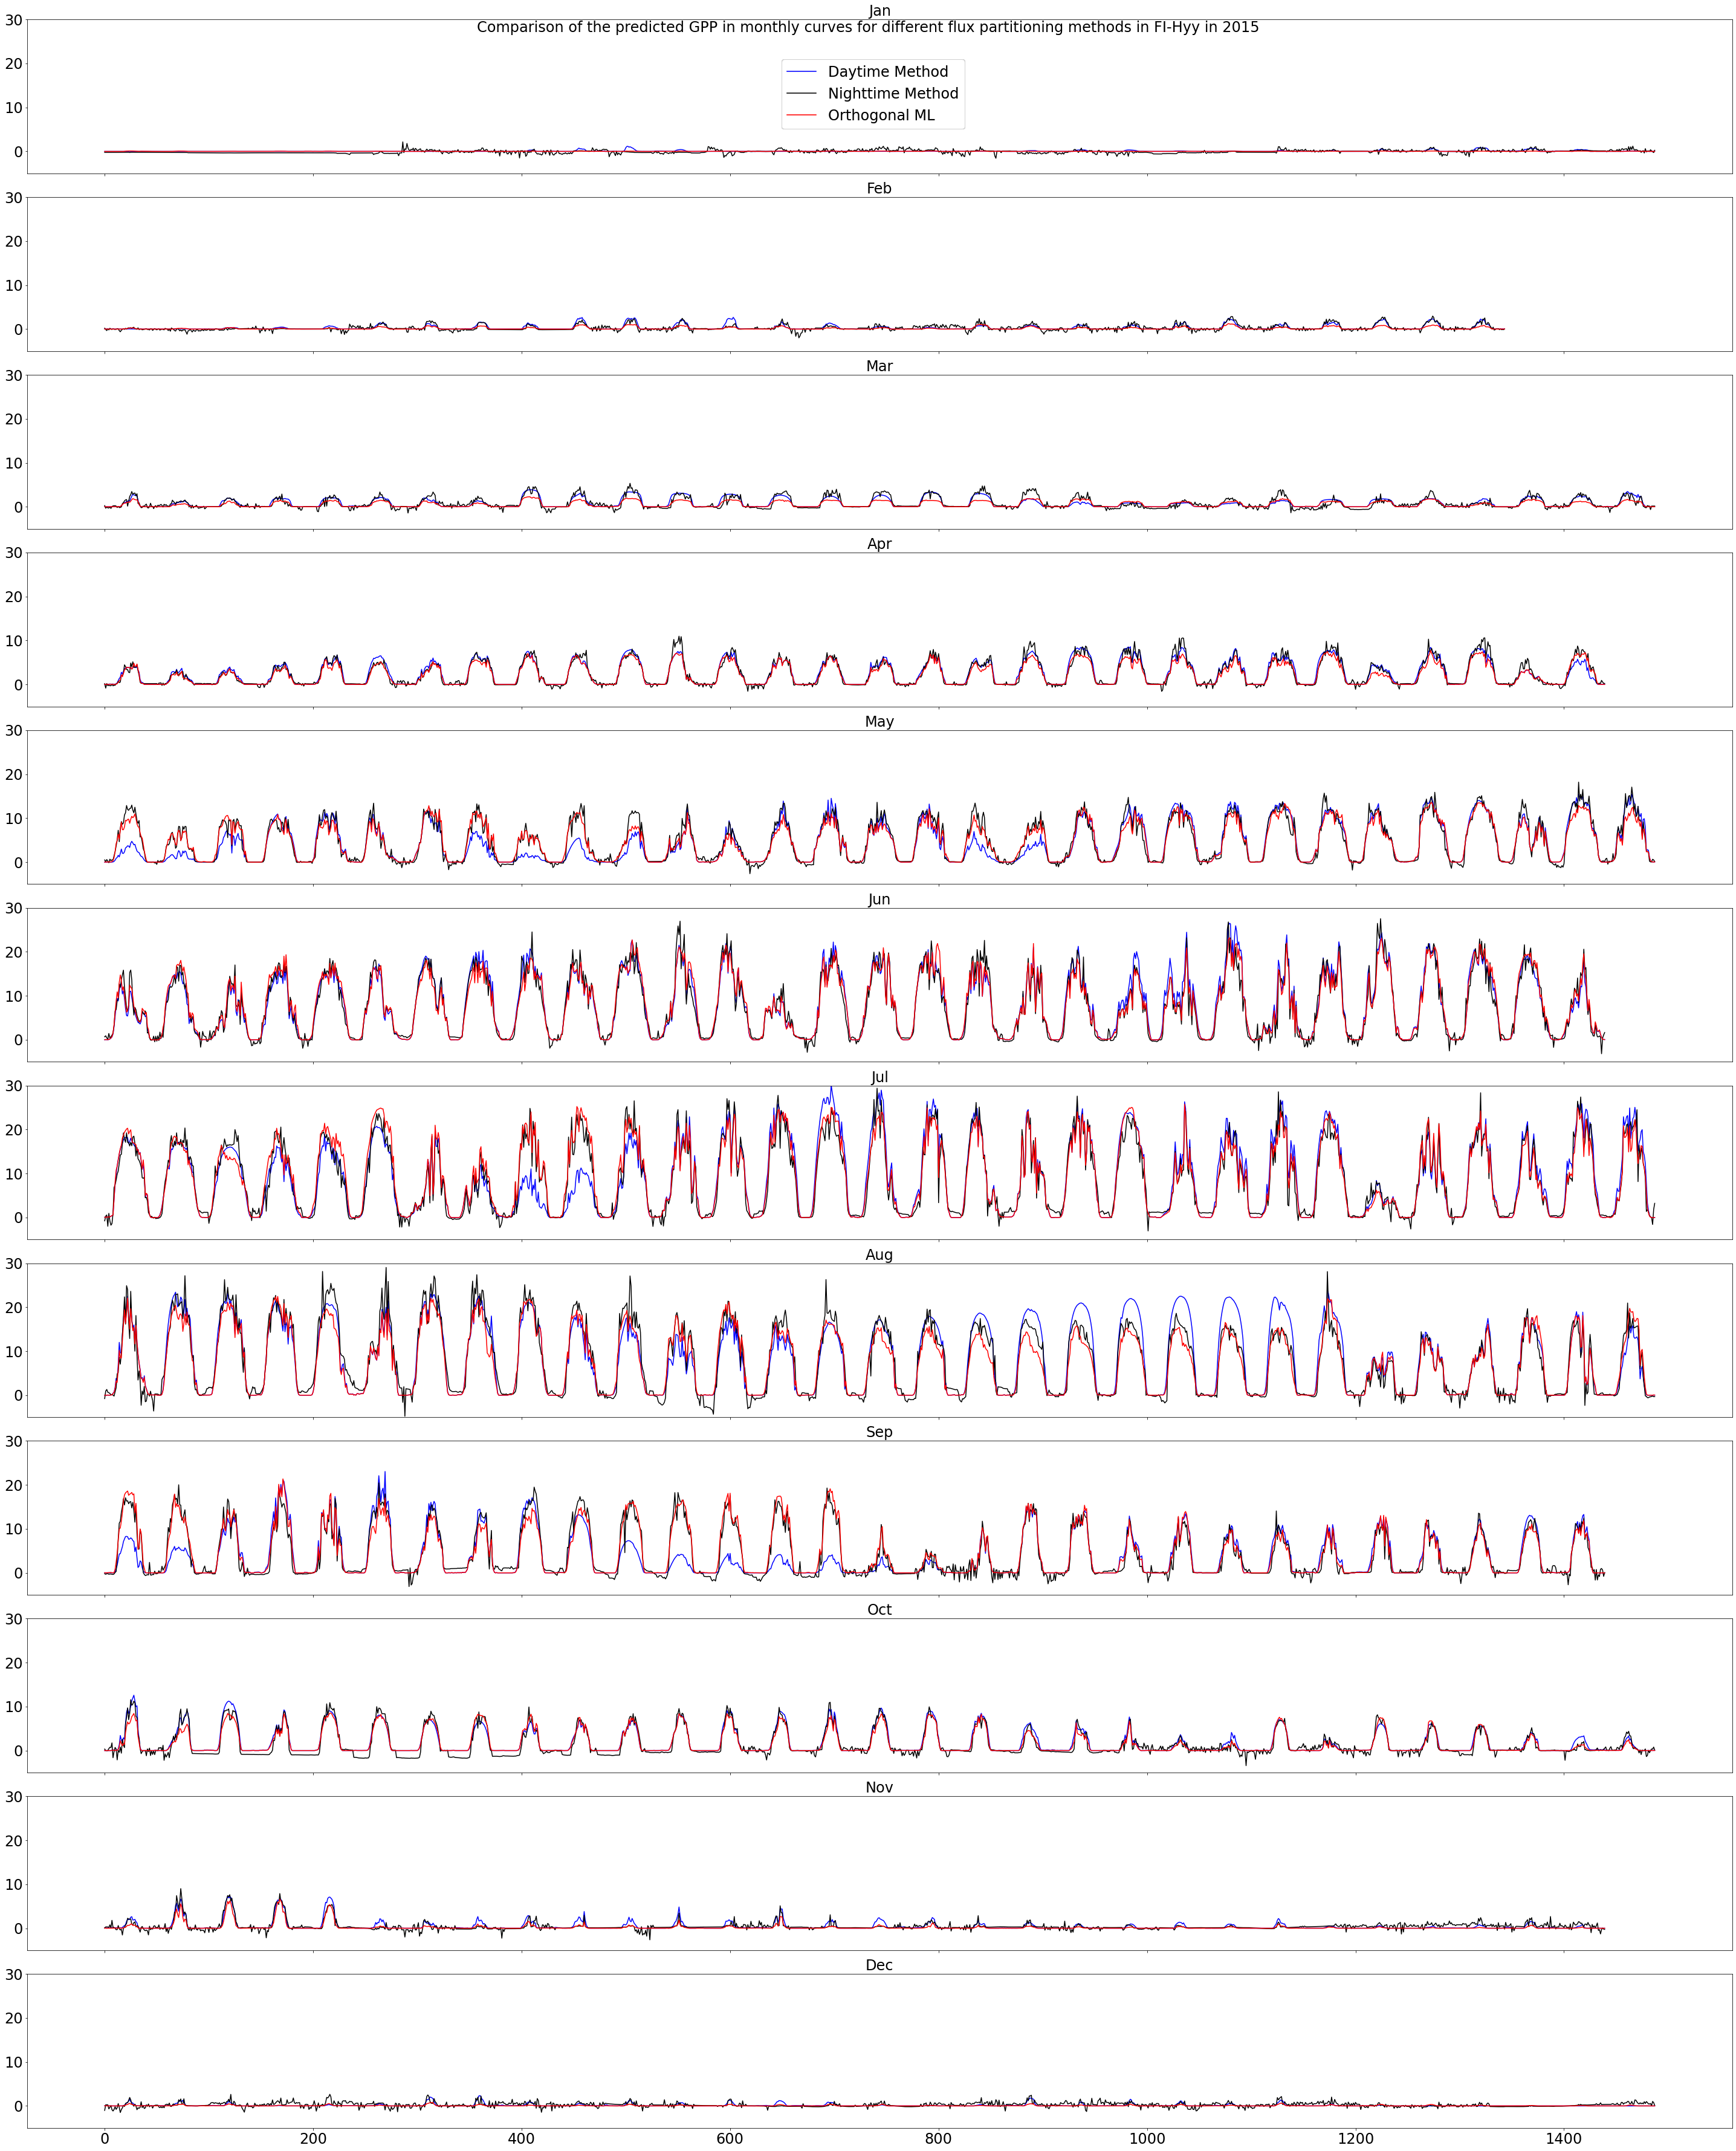

In [473]:
monthly_curves(exp.data, site='FI-Hyy', year=2015, res=False, flux='GPP', path='/usr/users/kcohrs/bayesian-q10', final='test')

In [169]:
exp.dml.est.__dict__

{'model_y': GradientBoostingRegressor(),
 'model_t': GradientBoostingRegressor(),
 'featurizer': None,
 'model_final': GradientBoostingRegressor(),
 'cv': 5,
 'discrete_treatment': False,
 'discrete_instrument': False,
 'random_state': None,
 'categories': 'auto',
 'mc_iters': None,
 'mc_agg': 'mean',
 '_ortho_learner_model_final': <econml.dml._rlearner._ModelFinal at 0x7f3ff58afc10>,
 '_ortho_learner_model_nuisance': <econml.dml._rlearner._ModelNuisance at 0x7f3ff58af6d0>,
 '_d_y': (),
 '_d_t': (),
 '_input_names': {'feature_names': ['VPD_n',
   'TA_n',
   'SW_POT_sm_n',
   'wdefcum_n',
   'SW_POT_sm_diff_n'],
  'output_names': ['NEE'],
  'treatment_names': ['T']},
 '_d_t_in': (),
 '_random_state': RandomState(MT19937) at 0x7F40D8059E40,
 '_d_x': (5,),
 '_d_w': None,
 '_d_z': None,
 'transformer': None,
 'z_transformer': None,
 '_models_nuisance': [[<econml.dml._rlearner._ModelNuisance at 0x7f3ff58af4f0>,
 'nuisance_scores_': ([[0.5341889566810316,
    0.517165860295365,
    0.5364873

In [446]:
from bayesian_q10.experiments.utility import *

indices = (exp.data['Year']==2015)

if exp.dataset_config['transform_T']:
    exp.data.loc[indices, 'T'], parameter = transform_T(x=exp.data.loc[indices, 'SW_IN'], 
                                                delta=exp.dataset_config['delta'], 
                                                data=exp.data.loc[indices,:],
                                                month_wise=exp.dataset_config['month_wise']
                                                )    
T = exp.data.loc[indices, 'T']            
X = exp.data.loc[indices, [var + '_n' for var in exp.X_var]]            

if not len(exp.W_var):
    W = None
else:
    W = exp.data.loc[indices, [var + '_n' for var in exp.W_var]]

if exp.dataset_config['syn']:
    Y = exp.data.loc[indices, 'NEE_syn']
else:
    Y = exp.data.loc[indices, 'NEE']
            

[ 0.09559357  0.39406545 -0.37405903]
[ 0.03312192  0.01838302 -0.59312195]
[ 0.06444883  0.02537968 -0.85326278]
[ 0.04439503  0.00426038 -1.38737916]
[ 0.0640886   0.00393608 -2.42268608]
[ 7.81582636e-02  2.90254954e-03 -4.42298194e+00]
[ 8.96082541e-02  3.08710143e-03 -5.15882694e+00]
[ 1.00656748e-01  4.22154235e-03 -5.12476561e+00]
[ 8.97108099e-02  3.74978015e-03 -3.75045792e+00]
[ 0.05755563  0.00350499 -2.25608004]
[ 0.0272163  -0.00200352 -1.18263846]
[ 0.03604157  0.00966256 -0.93442414]


In [477]:
from econml.dml import SparseLinearDML, LinearDML

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import clone
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import SGDRegressor

In [483]:
model_config = dict(
      min_samples_split = 50,
      min_samples_leaf = 50,
      max_depth=3,
      n_estimators=500,
      loss='ls')

In [484]:
model = GradientBoostingRegressor(**model_config)
model_t = model
model_y = clone(model_t)

In [485]:
model_t.fit(X, T)
t_fit = model_t.predict(X)

model_y.fit(X, Y)
y_fit = model_y.predict(X)

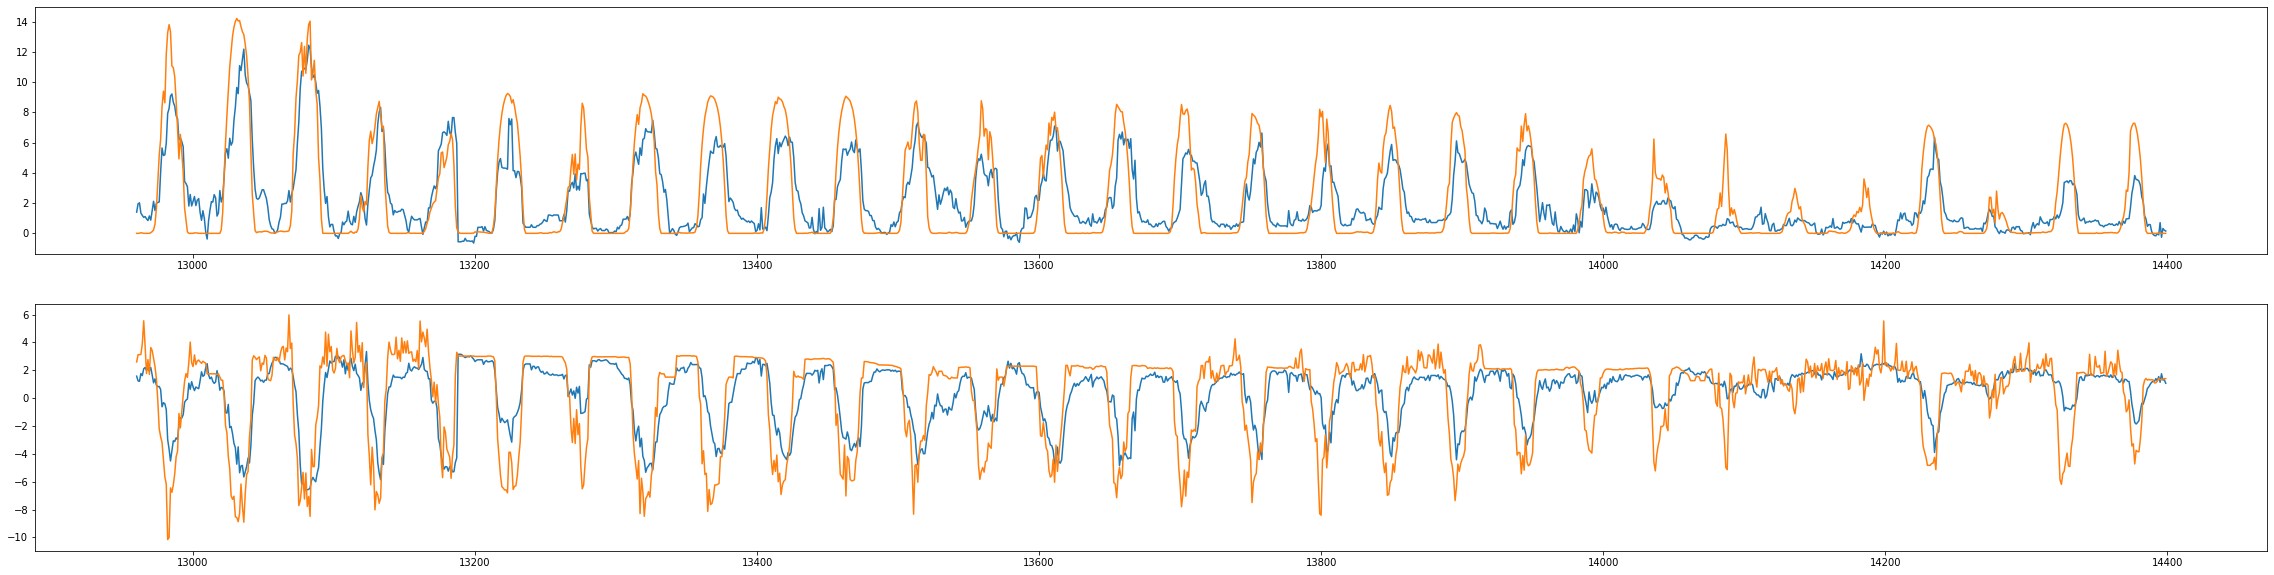

In [486]:
fig, ax = plt.subplots(2,1, figsize = (40, 10))
window = range(48*9*30,48*10*30)
values = np.array(range(len(y_fit)))[window]


ax[0].plot(values, t_fit[window])
ax[0].plot(values, T.values[window])

ax[1].plot(values, y_fit[window])
ax[1].plot(values, Y.values[window])


In [341]:
from econml.dml import NonParamDML
from sklearn.model_selection import GridSearchCV
model_reg = lambda: GridSearchCV(
                estimator=GradientBoostingRegressor(),
                param_grid={
                        'max_depth': [1, 2],
                         'min_samples_split': [2, 5, 10, 20, 40],
                        'n_estimators': [20, 50, 100, 200, 400],
                        'min_samples_leaf': [2, 5, 10, 20, 40]
                    }, cv=5, n_jobs=-1, scoring='neg_mean_squared_error'
                )

est = NonParamDML(model_y=model_reg(),
                  model_t=model_reg(),
                  model_final=model_reg(),
                 cv = 3)

In [327]:
exp.dml.est.__dict__

{'model_y': GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=10,
                           min_samples_split=10),
 'model_t': GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=10,
                           min_samples_split=10),
 'featurizer': None,
 'model_final': GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_leaf=10,
                           min_samples_split=10),
 'cv': 2,
 'discrete_treatment': False,
 'discrete_instrument': False,
 'random_state': None,
 'categories': 'auto',
 'mc_iters': None,
 'mc_agg': 'mean',
 '_ortho_learner_model_final': <econml.dml._rlearner._ModelFinal at 0x7f40080f75b0>,
 '_ortho_learner_model_nuisance': <econml.dml._rlearner._ModelNuisance at 0x7f40080f7820>,
 '_d_y': (),
 '_d_t': (),
 '_input_names': {'feature_names': ['VPD_n',
   'TA_n',
   'SW_POT_sm_n',
   'wdefcum_n',
   'SW_POT_sm_diff_n'],
  'output_names': ['NEE'],
  'treatment_names': ['T']},
 '_d_t_in': (),
 '_random_state': RandomState(

In [342]:
est.fit(Y, T, X=X, W=W)

In [344]:
est._models_nuisance[0][0]._model_y._model.best_params_, est._models_nuisance[0][1]._model_y._model.best_params_, est._models_nuisance[0][2]._model_y._model.best_params_

({'max_depth': 1,
  'min_samples_leaf': 5,
  'min_samples_split': 5,
  'n_estimators': 50},
 {'max_depth': 1,
  'min_samples_leaf': 5,
  'min_samples_split': 5,
  'n_estimators': 50},
 {'max_depth': 1,
  'min_samples_leaf': 20,
  'min_samples_split': 40,
  'n_estimators': 50})

In [345]:
est._models_nuisance[0][0]._model_t._model.best_params_, est._models_nuisance[0][1]._model_t._model.best_params_, est._models_nuisance[0][2]._model_t._model.best_params_

({'max_depth': 1,
  'min_samples_leaf': 5,
  'min_samples_split': 40,
  'n_estimators': 50},
 {'max_depth': 1,
  'min_samples_leaf': 5,
  'min_samples_split': 20,
  'n_estimators': 50},
 {'max_depth': 1,
  'min_samples_leaf': 20,
  'min_samples_split': 5,
  'n_estimators': 50})

In [374]:
est._ortho_learner_model_nuisance._model_y._model.__dict__

{'scoring': 'neg_mean_squared_error',
 'estimator': GradientBoostingRegressor(),
 'n_jobs': -1,
 'iid': 'deprecated',
 'refit': True,
 'cv': 5,
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'max_depth': [1, 2, 3],
  'min_samples_split': [5, 10, 20, 40],
  'n_estimators': [50, 100, 200, 400],
  'min_samples_leaf': [5, 10, 20, 40]}}

In [375]:
est._ortho_learner_model_final._model_final._model.__dict__

{'scoring': 'neg_mean_squared_error',
 'estimator': GradientBoostingRegressor(),
 'n_jobs': -1,
 'iid': 'deprecated',
 'refit': True,
 'cv': 5,
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'max_depth': [1, 2, 3],
  'min_samples_split': [5, 10, 20, 40],
  'n_estimators': [50, 100, 200, 400],
  'min_samples_leaf': [5, 10, 20, 40]},
 'multimetric_': False,
 'best_index_': 101,
 'best_score_': -758.9778269231922,
 'best_params_': {'max_depth': 2,
  'min_samples_leaf': 20,
  'min_samples_split': 10,
  'n_estimators': 100},
 'best_estimator_': GradientBoostingRegressor(max_depth=2, min_samples_leaf=20,
                           min_samples_split=10),
 'refit_time_': 1.0455222129821777,
 'scorer_': make_scorer(mean_squared_error, greater_is_better=False),
 'cv_results_': {'mean_fit_time': array([0.23928967, 0.47040749, 0.99400949, 1.91631174, 0.23653584,
         0.47939844, 0.99737029, 1.93185434, 0.23657112, 0.50248699,
    

In [363]:
est._ortho_learner_model_final._model_final._model.best_params_

{'max_depth': 2,
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'n_estimators': 100}

In [ ]:
est._models_nuisance[0][0]._model_t._model.best_params_, est._models_nuisance[0][1]._model_t._model.best_params_, est._models_nuisance[0][2]._model_t._model.best_params_

In [315]:
est.__dict__

{'model_y': GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
              param_grid={'max_depth': [2, 3], 'min_samples_leaf': [5, 20],
                          'min_samples_split': [5, 20],
                          'n_estimators': [100, 200]},
              scoring='neg_mean_squared_error'),
 'model_t': GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
              param_grid={'max_depth': [2, 3], 'min_samples_leaf': [5, 20],
                          'min_samples_split': [5, 20],
                          'n_estimators': [100, 200]},
              scoring='neg_mean_squared_error'),
 'featurizer': None,
 'model_final': GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
              param_grid={'max_depth': [2, 3], 'min_samples_leaf': [5, 20],
                          'min_samples_split': [5, 20],
                          'n_estimators': [100, 200]},
              scoring='neg_mean_squared_error'),
 'cv': 3,
 'discrete_tre

In [ ]:
dml.est = NonParamDML(model_y=model_y,
                    model_t=model_t,
                    model_final = model_final, 
                    **dml_config)
        
def fit(self, Y, X, T, W=None):
    self.est.fit(Y=Y, X=X, W=W, T=T, cache_values=True)
    self.gpp, self.reco, self.reco_res, self.nee, self.t, self.lue = self.get_estimators()

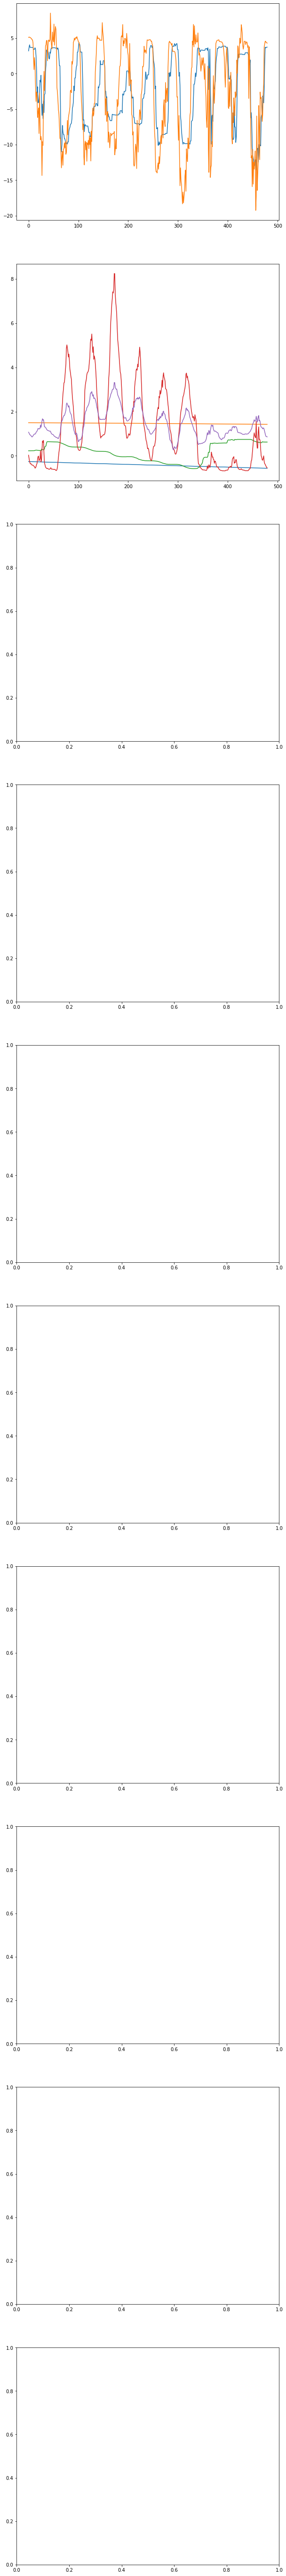

In [185]:
fig, ax = plt.subplots(10,1, figsize=(10,100))
window = range(48*180,48*190)
nees = [0,0,0,0,0,0,0,0,0,0]

#for i in range(10):
nees[0] = exp.dml.est._models_nuisance[0][0]._model_y.predict(X,W)[window]
t = Y.values[window]
SW_sm_diff = X['SW_POT_sm_diff_n'].values[window]
SW_sm = X['SW_POT_sm_n'].values[window]
wdefcum = X['wdefcum_n'].values[window]
vpd = X['VPD_n'].values[window]
ta = X['TA_n'].values[window]



ax[0].plot(range(len(t)),nees[0])
ax[0].plot(range(len(t)),t)

ax[1].plot(range(len(t)),SW_sm_diff)
ax[1].plot(range(len(t)),SW_sm)
ax[1].plot(range(len(t)),wdefcum)
ax[1].plot(range(len(t)),vpd)
ax[1].plot(range(len(t)),ta)


In [151]:
syn_data= pd.read_csv('/usr/users/kcohrs/bayesian-q10/data/Synthetic4BookChap.csv')

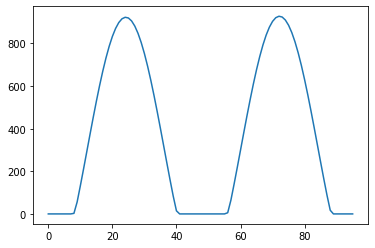

In [161]:
#plt.plot(X['SW_POT_sm'].values[120*48:122*48])
plt.plot(exp.data['SW_IN_POT'].values[120*48:122*48])

In [1038]:
experiment_utils.build_single_experiment(experiment_config, model_configs, dataset_config)

Congratulations! Experiment67 is ready!


In [1001]:
for relnoise in [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 2.0]:
    dataset_config['relnoise'] = relnoise
    experiment_config['comment'] = f'Syntehtic data at different noise levels: level {relnoise}.'
    experiment_utils.build_single_experiment(experiment_config, model_configs, dataset_config)

Congratulations! Experiment58 is ready!
Congratulations! Experiment59 is ready!
Congratulations! Experiment60 is ready!
Congratulations! Experiment61 is ready!
Congratulations! Experiment62 is ready!
Congratulations! Experiment63 is ready!
Congratulations! Experiment64 is ready!
Congratulations! Experiment65 is ready!


In [3]:
exp = experiment.FluxPartDML2()
exp.new('all')
exp.configs(experiment_config, dataset_config, model_configs)
#exp.prepare_data()
#exp.fit_models()
exp.all_analysis()

Create new experiment folder : /usr/users/kcohrs/bayesian-q10/exp/FPDML_all_2022-07-20_1
Starting with site FI-Hyy.
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
Finished site FI-Hyy


UnboundLocalError: local variable 'analysis_data' referenced before assignment

In [22]:
data = exp.data.copy()

In [34]:
import datetime

def time_to_dec(x):
    try:
        hour = datetime.datetime.strptime(x, '%H:%M:%S').time().hour
        minute = datetime.datetime.strptime(x, '%H:%M:%S').time().minute
    except:
        hour = x.hour
        minute = x.minute        
    
    if minute == 15:
        time = hour + 0.5
    else:
        time = hour + 1.0
    return time

def prep_std_partitioning(data):
    data_new = data[['Year', 'TA', 'doy', 'Time', 'VPD', 'SW_IN', 'NEE_syn']].copy()
    #data.drop('Unnamed: 0', axis=1, inplace=True)
    #data.drop(['VPD_n', 'SW_ratio', 'RECO_NT', 'RECO_DT', 'RECO_orth_res', 'code', 'GPP_NT', 'RECO_orth', 'site', 'Month', 'TA_n', 'wdefcum', 'LUE_orth', 'GPP_DT', 'NEE_orth', 'NIGHT'], axis=1, inplace=True)
    #data.drop('GPP_orth', axis=1, inplace=True)
    data_new['Hour'] = data_new.apply(lambda x: time_to_dec(x['Time']), axis=1)
    data_new.drop('Time', axis=1, inplace=True)
    data_new.rename(columns={'doy':'DoY', 'TA': 'Tair', 'SW_IN':'Rg', 'NEE_syn': 'NEE'}, inplace=True)
    data_new['Ustar'] = np.random.normal(1, 0.01, len(data_new))
    return data_new

In [37]:
data.to_csv('/usr/users/kcohrs/bayesian-q10/data/FLX_FI-Hyy_syn0_1.csv')

In [ ]:
dataset_config = dict(
                site_name = 'FI-Hyy',
                syn = False,
                Q10=1.5,
                relnoise=0.05,
                transform_T = True,
                month_wise=True,
                delta = 'heuristic3', #fixed value, max_heuristic, slope_heuristic 
                X = ['VPD', 'TA', 'SW_POT_sm', 'SW_POT_sm_diff', 'SW_IN_POT', 'wdefcum'],
                W = ['TS_1', 'TS_2'], #['SW_POT_sm', 'SW_POT_sm_diff'], #['wdefcum'],
                years = 'all', #'all'
                norm_type = 'standardize'
                )


model_y_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = 2,
                      min_samples_leaf = 5)
model_t_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = 2,
                      min_samples_leaf = 5)
model_final_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = 2,
                      min_samples_leaf = 5)
dml_config = dict(cv=10)

model_configs = dict(y = model_y_config,
                    t = model_t_config,
                    final= model_final_config,
                    dml =dml_config)

experiment_config = dict(experiment_type = "flux_partitioning",
                         comment="test",
                         seed=1000)

In [ ]:
exp = experiment.FluxPartDML2()
exp.new('FI-Hyy')
exp.configs(experiment_config, dataset_config, model_configs)
exp.prepare_data()
exp.fit_models()
#exp.all_analysis()

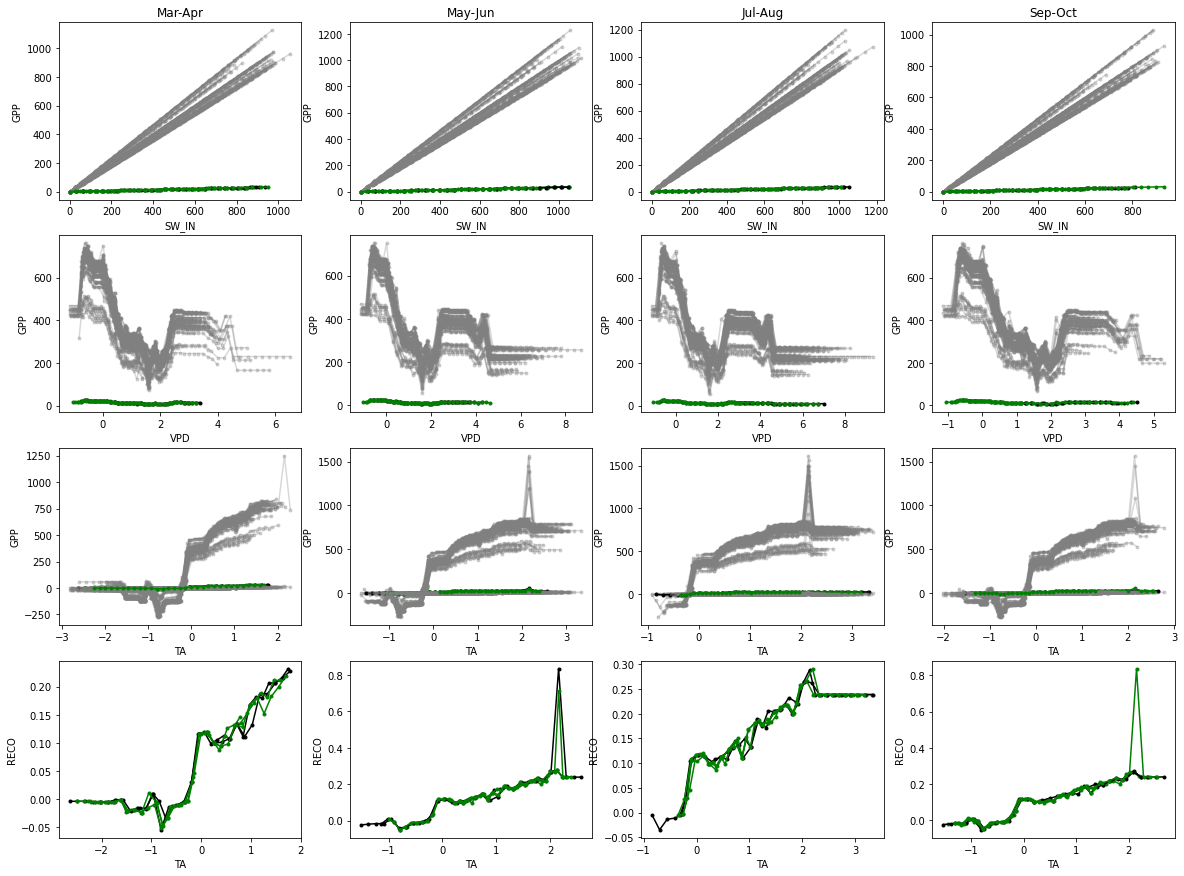

In [396]:
X_fixed_n_values = dict()
W_fixed_n_values = dict()
X_min_max_values = dict()
X_min_max_n_values = dict()
W_min_max_values = dict()
W_min_max_n_values = dict()


color_mapping = {'EBF' : 'green', 'MF': 'green', 'DBF': 'green', 'ENF': 'green', 'GRA' : 'green',
                 'GRA' : 'black', 'CRO' : 'black',
                 'SAV' : 'red'}

seasons = {2: 'Mar-Apr', 3: 'May-Jun', 4: 'Jul-Aug', 5: 'Sep-Oct'}

steps = 30
analysis_data['season'] = analysis_data.apply(lambda x: (x['Month']-1) // 2 + 1, axis=1)


fig, ax = plt.subplots(4, 4, figsize = (20, 15))

for season, months in seasons.items():
    for site in data['site'].unique():
        
        temp_data = data[(data['season']==season) & (data['site']==site)]        
        years = temp_data.groupby(['Year']).mean()["SW_IN"].to_dict().keys()
        code = temp_data['code'].unique()[0]
        color = color_mapping[code]        
    
        min_SW_IN = temp_data.groupby(['Year']).min()["SW_IN"].to_dict()
        max_SW_IN = temp_data.groupby(['Year']).max()["SW_IN"].to_dict()
    
        for param in dataset_config['X']:
            X_min_max_values[param] = [temp_data.groupby(['Year']).min()[param].to_dict(), temp_data.groupby(['Year']).max()[param].to_dict()]
            X_min_max_n_values[param] = [temp_data.groupby(['Year']).min()[param + '_n'].to_dict(), temp_data.groupby(['Year']).max()[param + '_n'].to_dict()]
            
        for param in dataset_config['W']:
            W_min_max_values[param] = [temp_data.groupby(['Year']).min()[param].to_dict(), temp_data.groupby(['Year']).max()[param].to_dict()]
            W_min_max_n_values[param] = [temp_data.groupby(['Year']).min()[param + '_n'].to_dict(), temp_data.groupby(['Year']).max()[param + '_n'].to_dict()]
            

        temp_data = analysis_data[analysis_data['Time'].apply(lambda x: x in ['11:45:00','12:15:00'])]
        for param in dataset_config['X']:
            X_fixed_n_values[param] = temp_data.groupby(['Year']).mean()[param + '_n'].to_dict()

        for param in dataset_config['W']:
            W_fixed_n_values[param] = temp_data.groupby(['Year']).mean()[param + '_n'].to_dict()

        SW_IN_fixed_values = temp_data.groupby(['Year']).mean()["SW_IN"].to_dict()

        for year in years:
            X_fixed = np.ones(shape=(steps, len(dataset_config['X']))) * (np.expand_dims(np.array([value[year] for value in X_fixed_n_values.values()]), 0))
            W_fixed = np.ones(shape=(steps, len(dataset_config['W']))) * (np.expand_dims(np.array([value[year] for value in W_fixed_n_values.values()]), 0))
            SW_IN_fixed = SW_IN_fixed_values[year] + np.ones(steps)
            
            TA_range = np.linspace(X_min_max_n_values['TA'][0][year], X_min_max_n_values['TA'][1][year], steps)
            VPD_range = np.linspace(X_min_max_n_values['VPD'][0][year], X_min_max_n_values['VPD'][1][year], steps)
            TA_n_range = np.linspace(X_min_max_n_values['TA'][0][year], X_min_max_n_values['TA'][1][year], steps)
            VPD_n_range = np.linspace(X_min_max_n_values['VPD'][0][year], X_min_max_n_values['VPD'][1][year], steps)
            SW_IN_range = np.linspace(min_SW_IN[year], max_SW_IN[year], steps)
            
            X = X_fixed.copy()
            SW_IN_mean =+ exp.dml.gpp(X, SW_IN_range)
            ax[0,season-2].plot(SW_IN_range, exp.dml.gpp(X_fixed, SW_IN_range), color="gray", marker=".", alpha=0.3)

            # VPD variation
            X[:,list(X_min_max_n_values.keys()).index('VPD')] = VPD_n_range
            VPD_mean =+ exp.dml.gpp(X, SW_IN_fixed)
            ax[1,season-2].plot(VPD_range, exp.dml.gpp(X, SW_IN_fixed), color="gray", marker=".", alpha=0.3)

            # TA variation
            X = X_fixed.copy()
            X[:,list(X_min_max_n_values.keys()).index('TA')] = TA_n_range
            TA_GPP_mean =+ exp.dml.gpp(X, SW_IN_fixed)
            ax[2,season-2].plot(TA_range, exp.dml.gpp(X, SW_IN_fixed), color="gray", marker=".", alpha=0.3)
            
            # TA variation in RECO
            TA_RECO_mean =+ exp.dml.reco(X, SW_IN_fixed, W_fixed)
            ax[2,season-2].plot(TA_range, exp.dml.reco(X, SW_IN_fixed, W_fixed), color="gray", marker=".", alpha=0.3)

            
        ax[0,season-2].plot(SW_IN_range,SW_IN_mean/steps, color=color, marker=".")
        ax[1,season-2].plot(VPD_range, VPD_mean/steps, color=color, marker=".")
        ax[2,season-2].plot(TA_range, TA_GPP_mean/steps, color=color, marker=".")
        ax[3,season-2].plot(TA_range, TA_RECO_mean/steps, color=color, marker=".")
        
        ax[0,season-2].set_xlabel("SW_IN")
        ax[1,season-2].set_xlabel("VPD")
        ax[2,season-2].set_xlabel("TA")
        ax[3,season-2].set_xlabel("TA")

        ax[0,season-2].set_ylabel("GPP")
        ax[1,season-2].set_ylabel("GPP")
        ax[2,season-2].set_ylabel("GPP")
        ax[3,season-2].set_ylabel("RECO")
    
        ax[0,season-2].set_title(months)

In [16]:
save = ['Time','Month', 'Year', 'doy', 'NIGHT', 'site', 'class',
        #'WS', 'WD'
        #'wdfcum', 'SW_ratio', 'SW_POT', 
        #'SW_POT_sm', 'SW_POT_sm_diff', 
        #'T_orth', 'LUE_orth', 'TA', 
        #'SW_IN', 'VPD', 'PA', 'P', 'WS', 
        #'LE', 'SWC_1', 'SWC_2', 'TS_1', 'TS_2', 
        'NEE', 'NEE_orth', 'GPP_DT', 
        'GPP_NT', 'GPP_orth', 'RECO_DT', 'RECO_NT', 
        'RECO_orth', 'RECO_orth_res']

exp.data['site'] = 'DE_Gri'
exp.data['class'] = 'ENF'
exp.data[save]




Time  Month  Year  doy  NIGHT    site class       NEE  NEE_orth  \
0       00:15:00      1  1996    1      1  DE_Gri   ENF  4.070000  0.627340   
1       00:45:00      1  1996    1      1  DE_Gri   ENF  3.938000  0.627340   
2       01:15:00      1  1996    1      1  DE_Gri   ENF  3.825450  0.627340   
3       01:45:00      1  1996    1      1  DE_Gri   ENF  2.815000  0.627340   
4       02:15:00      1  1996    1      1  DE_Gri   ENF  2.815000  0.627340   
...          ...    ...   ...  ...    ...     ...   ...       ...       ...   
438331  21:45:00     12  2020  366      1  DE_Gri   ENF  0.552510  1.342569   
438332  22:15:00     12  2020  366      1  DE_Gri   ENF  0.552510  1.342569   
438333  22:45:00     12  2020  366      1  DE_Gri   ENF  0.557130  1.342569   
438334  23:15:00     12  2020  366      1  DE_Gri   ENF  0.552035  1.342569   
438335  23:45:00     12  2020  366      1  DE_Gri   ENF  0.546205  1.316494   

        GPP_DT    GPP_NT  GPP_orth   RECO_DT   RECO_NT  RECO_orth  \
0          0.0 -3.319310       0.0  0.065476  0.750687   0.627340   
1          0.0 -3.195580       0.0  0.063704  0.742423   0.627340   
2          0.0 -3.091330       0.0  0.061953  0.734118   0.627340   
3          0.0 -2.080240       0.0  0.062088  0.734762   0.627340   
4          0.0 -2.079690       0.0  0.062203  0.735315   0.627340   
...        ...       ...       ...       ...       ...        ...   
438331     0.0 -0.299932       0.0  0.753371  0.252578   1.342569   
438332     0.0 -0.299490       0.0  0.754008  0.253020   1.342569   
438333     0.0 -0.305588       0.0  0.751877  0.251542   1.342569   
438334     0.0 -0.300433       0.0  0.751965  0.251602   1.342569   
438335     0.0 -0.293581       0.0  0.753437  0.252624   1.316494   

        RECO_orth_res  
0            0.444444  
1            0.476715  
2            0.412862  
3            0.397213  
4            0.475192  
...               ...  
438331       1.393790  
438332       1.438115  
438333       1.418802  
438334       1.370515  
438335       1.220671  

[438336 rows x 16 columns]

In [254]:
model_y_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = 2,
                      min_samples_leaf = 5)
model_t_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = 2,
                      min_samples_leaf = 5)
model_final_config = dict(model = 'GradientBoostingRegressor',
                      min_samples_split = 2,
                      min_samples_leaf = 5)
dml_config = dict(cv=10)

dml = models.dml_fluxes(model_y_config, model_t_config, model_final_config, dml_config)

In [272]:
dml.fit(Y,X,T,W)

In [161]:
from oneflux.tools.partition_nt import run_partition_nt

In [145]:
df = pd.read_csv('../data/Synthetic4BookChap.csv')
SW_POT_sm_year = df.iloc[0:17520]['SW_POT_sm']
times = len(df)//17520
rest = len(df)- len(SW_POT_sm_year) * times
SW_POT_sm = np.concatenate((np.tile(SW_POT_sm_year,(times)), SW_POT_sm[:rest]))

In [156]:
df.columns

Index(['siteID', 'DateTime', 'wdefCum', 'H2Ostor1', 'H2Ostor2', 'Drainage',
       'SW_POT_sm', 'SW_POT_sm_diff', 'useit', 'seqID', 'RUE_syn', 'GPP_syn',
       'Rb_syn', 'RECO_syn', 'NEE_syn', 'doy', 'timeofday', 'GPP_DT', 'GPP_NT',
       'H_CORR', 'H', 'H_QC', 'H_RANDUNC', 'H_RANDUNC_N', 'LE_CORR', 'LE',
       'LE_QC', 'LE_RANDUNC', 'LE_RANDUNC_N', 'NEE', 'NEE_QC', 'NEE_RANDUNC',
       'NEE_RANDUNC_N', 'NETRAD', 'P', 'PA', 'PPFD_DIF', 'PPFD_IN', 'PPFD_OUT',
       'RECO_DT', 'RECO_NT', 'SWC_1', 'SWC_1_QC', 'SWC_2', 'SWC_2_QC', 'SW_IN',
       'SW_IN_QC', 'SW_IN_POT', 'TA', 'TA_QC', 'TS_1', 'TS_2', 'TS_1_QC',
       'TS_2_QC', 'VPD', 'VPD_QC', 'WS', 'year', 'hourClass', 'modisweek',
       'clearIndex', 'GPP_NT_QC', 'GPP_DT_QC', 'H_QC_OK', 'LE_QC_OK',
       'NEE_QC_OK', 'SWC_1_QC_OK', 'SWC_2_QC_OK', 'SW_IN_QC_OK', 'TA_QC_OK',
       'TS_1_QC_OK', 'TS_2_QC_OK', 'VPD_QC_OK', 'GPP_NT_QC_OK',
       'GPP_DT_QC_OK'],
      dtype='object')

In [160]:
FILENAME_TEMPLATE = "nee_{prod}_{perc}_{s}_{y}{add}.{e}"
PROD_TO_COMPARE = ['c', 'y']
PERC_TO_COMPARE = ['1.25', '3.75', '6.25', '8.75', '11.25', '13.75', '16.25', '18.75',
                   '21.25', '23.75', '26.25', '28.75', '31.25', '33.75', '36.25', '38.75',
                   '41.25', '43.75', '46.25', '48.75', '51.25', '53.75', '56.25', '58.75',
                   '61.25', '63.75', '66.25', '68.75', '71.25', '73.75', '76.25', '78.75',
                   '81.25', '83.75', '86.25', '88.75', '91.25', '93.75', '96.25', '98.75',
                   '50', ]
datadir = '/usr/users/kcohrs/bayesian-q10/data/Synthetic4BookChap.csv'
siteid = 'AT-Neu'
sitedir = 

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [137]:
df['SW_POT_sm']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
192859   NaN
192860   NaN
192861   NaN
192862   NaN
192863   NaN
Name: SW_POT_sm, Length: 192864, dtype: float64

In [146]:
len(SW_POT_sm)

192864

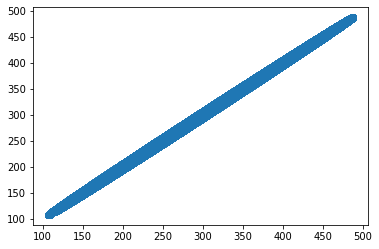

In [147]:
plt.scatter(SW_POT_sm, df['SW_POT_sm'])

In [124]:
df

siteID              DateTime    wdefCum   H2Ostor1    H2Ostor2  \
0       AT-Neu  2002-01-01T00:15:00Z   0.000000  40.000000  160.000000   
1       AT-Neu  2002-01-01T00:45:00Z  -0.000379  39.999659  159.999962   
2       AT-Neu  2002-01-01T01:15:00Z  -0.000758  39.999318  159.999924   
3       AT-Neu  2002-01-01T01:45:00Z  -0.001204  39.998916  159.999880   
4       AT-Neu  2002-01-01T02:15:00Z   0.000000  40.000000  160.000000   
...        ...                   ...        ...        ...         ...   
192859  AT-Neu  2012-12-31T21:45:00Z -66.446636  40.000000   93.553364   
192860  AT-Neu  2012-12-31T22:15:00Z -66.440884  40.000000   93.559116   
192861  AT-Neu  2012-12-31T22:45:00Z -66.435324  40.000000   93.564676   
192862  AT-Neu  2012-12-31T23:15:00Z -66.429510  40.000000   93.570490   
192863  AT-Neu  2012-12-31T23:45:00Z -66.423950  40.000000   93.576050   

        Drainage  SW_POT_sm  SW_POT_sm_diff  useit  seqID  ...  NEE_QC_OK  \
0          0.000        NaN             NaN  False      1  ...          1   
1          0.000        NaN             NaN  False      1  ...          1   
2          0.000        NaN             NaN  False      1  ...          1   
3          0.001        NaN             NaN  False      1  ...          1   
4          0.000        NaN             NaN   True      1  ...          1   
...          ...        ...             ...    ...    ...  ...        ...   
192859     0.000        NaN             NaN  False   2009  ...          1   
192860     0.000        NaN             NaN  False   2009  ...          1   
192861     0.000        NaN             NaN  False   2009  ...          1   
192862     0.000        NaN             NaN  False   2009  ...          1   
192863       NaN        NaN             NaN  False   2009  ...          1   

        SWC_1_QC_OK  SWC_2_QC_OK  SW_IN_QC_OK  TA_QC_OK  TS_1_QC_OK  \
0                 0            0            1         1           1   
1                 0            0            1         1           1   
2                 0            0            1         1           1   
3                 0            0            1         1           1   
4                 0            0            1         1           1   
...             ...          ...          ...       ...         ...   
192859            1            1            1         1           1   
192860            1            1            1         1           1   
192861            1            1            1         1           1   
192862            1            1            1         1           1   
192863            1            1            1         1           1   

        TS_2_QC_OK  VPD_QC_OK  GPP_NT_QC_OK  GPP_DT_QC_OK  
0                0          1             1             1  
1                0          1             1             1  
2                0          1             1             1  
3                0          1             1             1  
4                0          1             1             1  
...            ...        ...           ...           ...  
192859           1          1             1             1  
192860           1          1             1             1  
192861           1          1             1             1  
192862           1          1             1             1  
192863           1          1             1             1  

[192864 rows x 75 columns]

In [75]:
data = syntheticdataset(df, 1.5, 0.05)

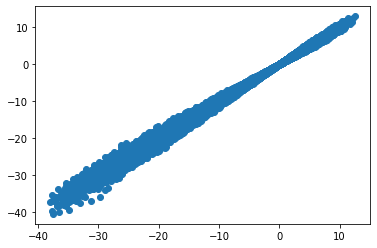

In [67]:
plt.scatter(data['NEE_syn_clean'], data['NEE_syn'])

In [ ]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'

# The Data

In [100]:
df = pd.read_csv('../data/Synthetic4BookChap.csv')
df = df[['DateTime', 'wdefCum', 'SW_POT_sm', 'SW_POT_sm_diff', 
         'RUE_syn', 'RECO_syn', 'GPP_syn', 'NEE_syn', 'NEE', 
          'P', 'PA', 'RECO_DT', 'GPP_DT', 'GPP_NT',
         'RECO_NT', 'SW_IN', 'TA', 'VPD', 'WS', 'SW_IN_POT']]
df = df.dropna()
print(df.columns)

Index(['DateTime', 'wdefCum', 'SW_POT_sm', 'SW_POT_sm_diff', 'RUE_syn',
       'RECO_syn', 'GPP_syn', 'NEE_syn', 'NEE', 'P', 'PA', 'RECO_DT', 'GPP_DT',
       'GPP_NT', 'RECO_NT', 'SW_IN', 'TA', 'VPD', 'WS', 'SW_IN_POT'],
      dtype='object')


### What are the variables we eventually want to include?
* DateTime
* wdefCum (water deficit?)
* P (precipitation)
* PA (atmospheric pressure)
* SWC (soil water content)
* VPD (vapor pressure deficit)
* WS (wind speed)
* TA (atmospheric temperature)


### LUE
According to the LUE model (see https://www.sciencedirect.com/science/article/pii/S0168192321003944#eqn0001) the full factorization should be something like:

$GPP = \epsilon \cdot APAR = \epsilon_{max} \cdot fT \cdot fVPD \cdot fW \cdot fL \cdot fCI \cdot PAR \cdot FAPAR $

where 

* LUE: light-use-efficiency $\epsilon$
* $\epsilon = \epsilon_{max} \cdot fX$ represents all the photosynthetic processes under certain light at the canopy scale
* $fX$: responses and sensitivities to environmental factors (TA, VPD, W, aridity index, predicipation index, land surface water index, evaporative fraction, diffuse radiation [through cloudiness index or sunlit/shaded leaves separation], CO2 concentration - mostly neglected and indirectly included in fVPD)
* $\epsilon_{max}$ is the maximum light-use-efficiency
* APAR: Absorbed photosynthetically active radiation
$ APAR = PAR \cdot FAPAR$
* PAR: photosynthetically active radiation
* FAPAR: fraction of absorbed photosynthetically active radiation
* Some models:$fL$ partial sensitivity function of APAR to account for saturation effects


Question:
    
SW_POT - SW_IN - SW_IN_POT - PAR - APAR - FAPAR - global photon radiation

* What is the potential shortwave radiation in contrast to the incoming shortwave? The cloudiness index seems to be a decisive factor here: the cloudiness index cuts of the radiation/the potential radiation is independent of that. Why would you want to use the potential radiation?
* Soil moisture: -> water content? Water deficit Cum?


Hence we use:
* SW_IN_POT as the treatment (seems like you somehow need to go for clearindex if you want to use SW_IN_POT)
* We use SWC, VPD, Temperature as other explainable variables
* And we include time (day and year) as cycles
* Potentially: P, PA, WS, clearindex

# Generate Data to see if approach can entangle it

In [8]:
df["Date"] = pd.to_datetime(df['DateTime']).dt.date
df["Time"] = pd.to_datetime(df['DateTime']).dt.time
df["Month"] = pd.to_datetime(df['Date']).dt.month
df["Year"] = pd.to_datetime(df['Date']).dt.year
df["doy"] = pd.to_datetime(df['DateTime']).dt.dayofyear
df_1 = df[df['Year'].isin(range(2008,2009))].copy()
df_2 = df[df['Year'].isin(range(2009,2010))].copy()       

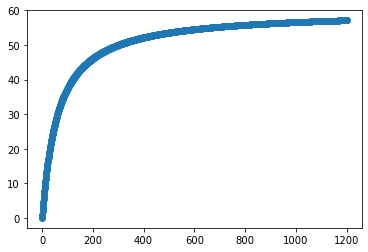

In [120]:
x_test = np.linspace(0,1200, 1200)
plt.scatter(x_test, hyperbolic_transform(x_test, 20/1200,))

In [10]:
for columns in ['TA', 'VPD', 'NEE_syn', 'SW_IN', 'wdefCum', 'SW_POT_sm', 'SW_POT_sm_diff', 'NEE']:
    df_1[columns + '_normed'] = (df_1[columns].loc[:]-df_1[columns].mean())/df_1[columns].std()
    df_2[columns + '_normed'] = (df_2[columns].loc[:]-df_1[columns].mean())/df_1[columns].std()
    df[columns + '_normed'] = (df[columns].loc[:]-df_1[columns].mean())/df_1[columns].std()

## Some examples
### Synthetic with exact predictors -> including Q10
* data = _syn
* W = ['SW_POT_sm', 'SW_POT_sm_diff']
* linear = True

### Synthetic with wdefCum (not exact exact) 
* data = _syn
* W = ['wdefCum']
* linear = True

### True data linear light curve
* data = ''
* W = ['wdefCum']
* linear = True

### True data transformed light curve
* data = ''
* W = ['wdefCum']
* linear = False, alpha=10, beta=1400


In [65]:
df['SW_IN'].max()

In [112]:
#def hyperbolic_transform(x, alpha=20, beta=600, linear=False):   #alpha=10, beta=1400
#    if linear:
#        return x
#    else:
#        return alpha*beta*x/(alpha*x+beta)    

def hyperbolic_transform(x, delta=10/1200, linear=False):   #alpha=10, beta=1400
    if linear:
        return x
    else:
        return x/(delta*x+1)    


data = '' #'_syn'
W_estimators = ['wdefCum'] #['SW_POT_sm', 'SW_POT_sm_diff']
T_estimator = ['SW_IN']
X_estimators = ['VPD', 'TA']


Y = df[['NEE' + data]].values.ravel()
Y_normed = df[['NEE' + data + '_normed']].values.ravel()

T = hyperbolic_transform(df[T_estimator]).values.ravel()
T_normed = df[[estimator + '_normed' for estimator in T_estimator]].values.ravel()

X = df[X_estimators]
X_normed = df[[estimator + '_normed' for estimator in X_estimators]]

W = df[W_estimators]
W_normed = df[[estimator + '_normed' for estimator in W_estimators]]


# Subset 1 for training
Y_1 = df_1[['NEE' + data]].values.ravel()
Y_1_normed = df_1[['NEE' + data + '_normed']].values.ravel()

T_1 = hyperbolic_transform(df_1[T_estimator]).values.ravel()
T_1_normed = df_1[[estimator + '_normed' for estimator in T_estimator]].values.ravel()

X_1 = df_1[X_estimators]
X_1_normed = df_1[[estimator + '_normed' for estimator in X_estimators]]

W_1 = df_1[W_estimators]
W_1_normed = df_1[[estimator + '_normed' for estimator in W_estimators]]


# Subset 2 for testing
Y_2 = df_2[['NEE' + data]].values.ravel()
Y_2_normed = df_2[['NEE' + data + '_normed']].values.ravel()

T_2 = hyperbolic_transform(df_2[T_estimator])
T_2_normed = df_2[[estimator + '_normed' for estimator in T_estimator]]

X_2 = df_2[X_estimators]
X_2_normed = df_2[[estimator + '_normed' for estimator in X_estimators]]

W_2 = df_2[W_estimators]
W_2_normed = df_2[[estimator + '_normed' for estimator in W_estimators]]


# Orthogonal Machine Learning

What are potential models that we could use?

NonParamDML only for one dimensional continuous treatments!
* LinearRegression
* SVC
* GradientBoostingRegression
* RandomForestRegressor, 
* Own Neural Networks
* WeightedLasso

(One can add WeightedModelWrapper)

(DMLOrthoForest/CausalForestDML)

When to use the forest based estimators:
"Thus you should use these methods if you have many features, you have no good idea how your effect heterogeneity looks like and you want confidence intervals."

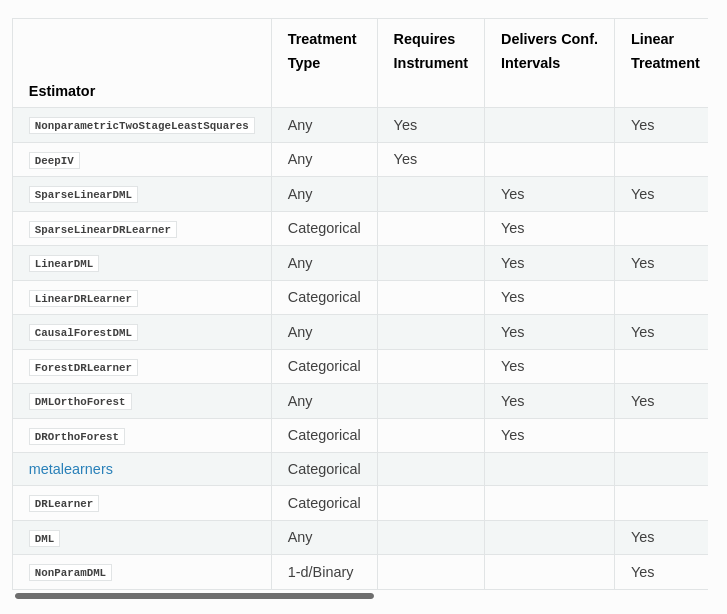

## The three estimators

* model_y estimates NEE from the input variables
* model_t estimates SW_In from the input variables
* model_final finally estimates the RUE from the residuals 

In [92]:
from econml.dml import DML, LinearDML, SparseLinearDML, NonParamDML, CausalForestDML, KernelDML
from econml.utilities import WeightedModelWrapper

from sklearn.linear_model import LassoCV, LinearRegression, PoissonRegressor
from sklearn.ensemble import GradientBoostingRegressor,  RandomForestRegressor 
from sklearn.base import clone
from sklearn.model_selection import train_test_split
#from sklearn_extensions.extreme_learning_machines.elm import ELMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=8
polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())

from doubleml import DoubleMLData
from doubleml import DoubleMLPLR
import doubleml as dml
from doubleml.datasets import make_plr_CCDDHNR2018


### Simple GradientBoosting

In [113]:
est = NonParamDML(model_y=GradientBoostingRegressor(),
                model_t=GradientBoostingRegressor(),
                model_final = GradientBoostingRegressor(), cv=10)
est.fit(Y_1, T_1, X=X_1_normed, W=W_1_normed, cache_values=True)

In [114]:
def gpp(x, t):
    return -est.const_marginal_effect(x)*t

def reco(x, t, w=None):
    return np.mean([est._models_nuisance[0][i]._model_y.predict(x, w)-est.const_marginal_effect(x)*(est._models_nuisance[0][i]._model_t.predict(x, w)) for i in range(len(est._models_nuisance[0]))], axis=0)

def nee(x, t, w=None):
    return -gpp(x, t) + reco(x, t, w)

def t(x, w=None):
    return np.mean([est._models_nuisance[0][i]._model_t.predict(x, w) for i in range(len(est._models_nuisance[0]))], axis=0)

In [115]:
df['SW_orth'] = t(X_normed, W_normed)
df['NEE_orth'] = nee(X_normed, T, W_normed)
df['RECO_orth'] = reco(X_normed, T, W_normed)
df['GPP_orth'] = gpp(X_normed, T)

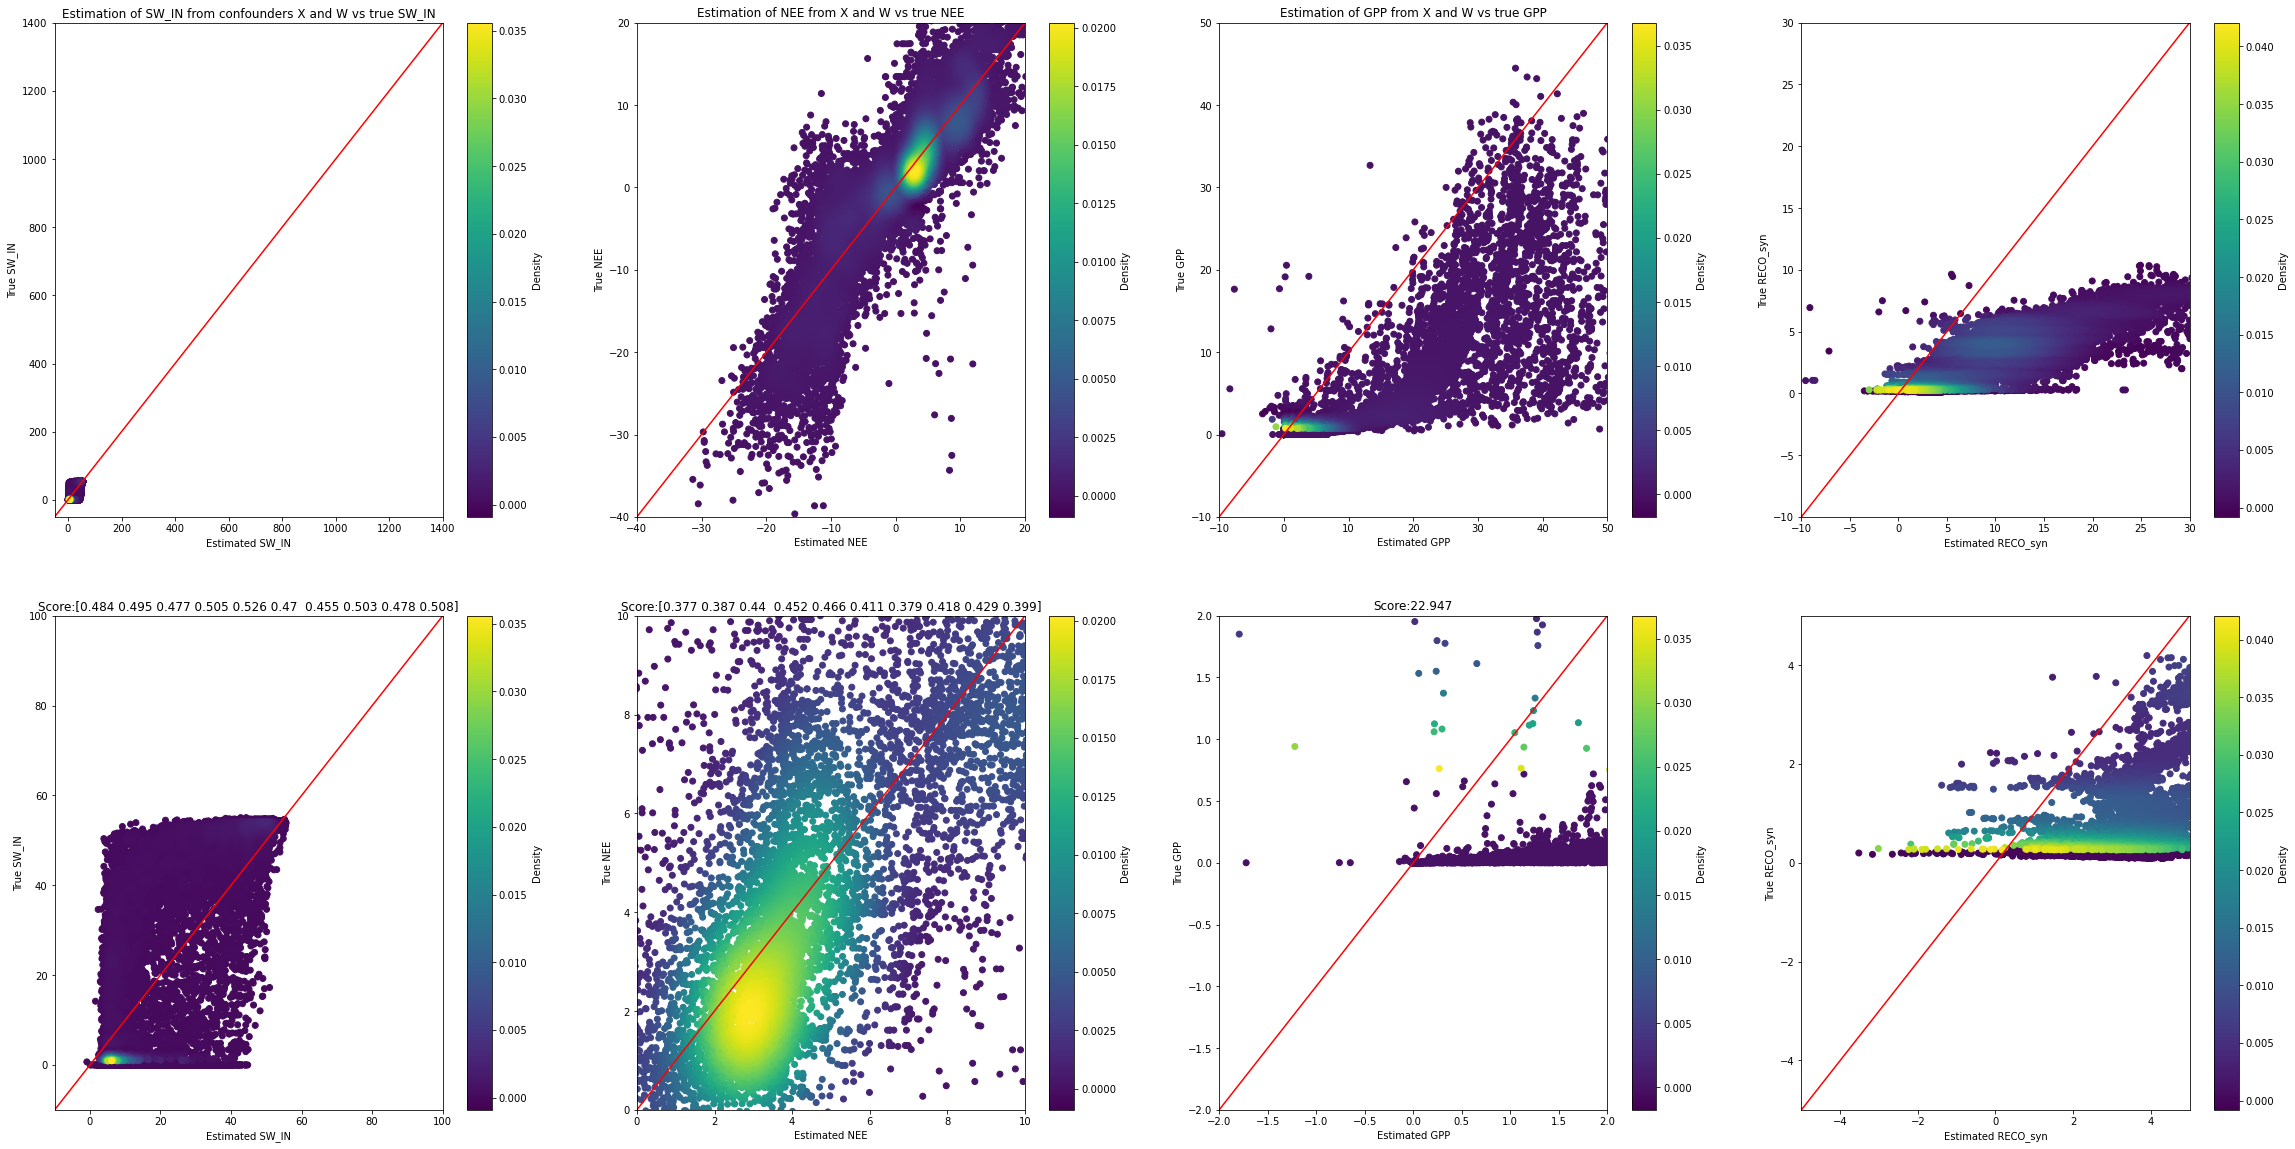

In [116]:
fig, ax = plt.subplots(2, 4, figsize = (40, 20))

#x, y = est.models_t[0][0].predict(XW_1_normed.values), T_1
SW, y = t(X_1_normed, W_1_normed), T_1
density_scatter(SW,y,bins = [30,30], ax=ax[0,0], fig=fig, cmap='viridis')
ax[0,0].plot([-50,1400], [-50,1400], color = 'red')
ax[0,0].set_xlim(-50, 1400)
ax[0,0].set_ylim(-50, 1400)
ax[0,0].set_xlabel('Estimated SW_IN')
ax[0,0].set_ylabel('True SW_IN')
ax[0,0].set_title('Estimation of SW_IN from confounders X and W vs true SW_IN')

density_scatter(SW,y,bins = [30,30], ax=ax[1,0], fig=fig, cmap='viridis')
ax[1,0].plot([-10,100], [-10,100], color = 'red')
ax[1,0].set_xlim(-10, 100)
ax[1,0].set_ylim(-10, 100)
ax[1,0].set_xlabel('Estimated SW_IN')
ax[1,0].set_ylabel('True SW_IN')
ax[1,0].set_title(f'Score:{np.array(est.nuisance_scores_t[0]).round(3)}')
#T_1_res = np.abs(est.models_t[0][0].predict(np.stack([X_1_normed.values[:,0], X_1_normed.values[:,1],  W_1_normed.values[:,0]]).transpose()) - T_1)

NEE, y = nee(X_1_normed, T_1, W_1_normed), Y_1
#x, y = est.models_y[0][0].predict(XW_1_normed.values), Y_1
density_scatter(NEE, y, bins = [30,30], ax=ax[0,1], fig=fig, cmap='viridis')
ax[0,1].set_xlim(-40, 20)
ax[0,1].set_ylim(-40, 20)
ax[0,1].plot([-40,20], [-40,20], color = 'red')
ax[0,1].set_title('Estimation of NEE from X and W vs true NEE')
ax[0,1].set_xlabel('Estimated NEE')
ax[0,1].set_ylabel('True NEE')

density_scatter(NEE, y, bins = [30,30], ax=ax[1,1], fig=fig, cmap='viridis')
ax[1,1].set_xlim(0, 10)
ax[1,1].set_ylim(0, 10)
ax[1,1].plot([-40,20], [-40,20], color = 'red')
ax[1,1].set_title(f'Score:{np.array(est.nuisance_scores_y[0]).round(3)}')
ax[1,1].set_xlabel('Estimated NEE')
ax[1,1].set_ylabel('True NEE')
#Y_1_res = np.abs(est.models_y[0][0].predict(np.stack([X_1_normed.values[:,0], X_1_normed.values[:,1],  W_1_normed.values[:,0]]).transpose()) - Y_1)

GPP, y = gpp(X_1_normed, T_1), df_1['GPP_syn'].values
density_scatter(GPP,y,  bins = [30,30], ax=ax[0,2], fig=fig, cmap='viridis')
ax[0,2].set_xlim(-10, 50)
ax[0,2].set_ylim(-10, 50)
ax[0,2].plot([-10, 50], [-10, 50], color = 'red')
ax[0,2].set_title('Estimation of GPP from X and W vs true GPP')
ax[0,2].set_xlabel('Estimated GPP')
ax[0,2].set_ylabel('True GPP')

density_scatter(GPP, y,  bins = [30,30], ax=ax[1,2], fig=fig, cmap='viridis')
ax[1,2].set_xlim(-2, 2)
ax[1,2].set_ylim(-2, 2)
ax[1,2].plot([-10, 50], [-10, 50], color = 'red')
ax[1,2].set_title(f'Score:{np.array(est.score_).round(3)}')
ax[1,2].set_xlabel('Estimated GPP')
ax[1,2].set_ylabel('True GPP')

#GPP_res = np.abs(-est.const_marginal_effect(X_1_normed)*T_1 - df_1['GPP_syn'])

RECO, y = reco(X_1_normed, T_1, W_1_normed), df_1['RECO_syn'].values
density_scatter(RECO,y,bins = [30,30], ax=ax[0,3], fig=fig, cmap='viridis')
ax[0,3].plot([-10,30], [-10,30], color = 'red')
ax[0,3].set_xlim(-10, 30)
ax[0,3].set_ylim(-10, 30)
ax[0,3].set_xlabel('Estimated RECO_syn')
ax[0,3].set_ylabel('True RECO_syn')
#ax[0,3].set_title('Estimation of SW_IN from confounders X and W vs true SW_IN')

density_scatter(RECO,y,bins = [30,30], ax=ax[1,3], fig=fig, cmap='viridis')
ax[1,3].plot([-10,10], [-10,10], color = 'red')
ax[1,3].set_xlim(-5, 5)
ax[1,3].set_ylim(-5, 5)
ax[1,3].set_xlabel('Estimated RECO_syn')
ax[1,3].set_ylabel('True RECO_syn')
#ax[1,3].set_title(f'Score:{est.nuisance_scores_t}')

Reco_res = np.abs(df_1['NEE_syn']-est.const_marginal_effect(X_1_normed)*T_1 - df_1['RECO_syn'])


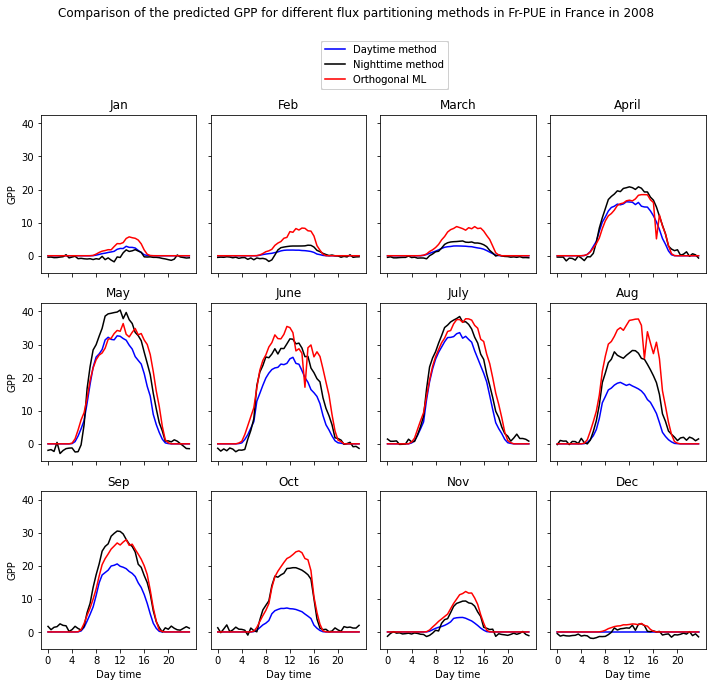

In [117]:
fig, axes = plt.subplots(3,4, figsize=(10,10), sharex=True, sharey=True)
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]


for month, ax in enumerate(axes.flatten()):
    df_temp = df[(df["Month"] == month+1) & (df["Year"] == 2008)]
    GPP_DT = df_temp.groupby("Time")["GPP_DT"].mean()
    GPP_NT = df_temp.groupby("Time")["GPP_NT"].mean()
    GPP_orth = df_temp.groupby("Time")["GPP_orth"].mean()
    GPP_GT = df_temp.groupby("Time")["GPP_syn"].mean()
    
    ax.plot(GPP_DT.values, color = "blue", label = "Daytime method")
    ax.plot(GPP_NT.values, color = "black", label = "Nighttime method")
    ax.plot(GPP_orth.values, color = "red", label = "Orthogonal ML")
    #ax.plot(GPP_GT.values, color = "yellow", label = "synthetic GT")
    handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, loc=(0.45, 0.87))
    
    ax.set_xticks(list(range(0,48,8)))
    ax.set_xticklabels(list(range(0,24,4)), fontsize = 10)
    if month // 4 == 2:
        ax.set_xlabel("Day time")
    if month % 4 == 0:
        ax.set_ylabel("GPP")
    ax.set_title(months[month])

fig.suptitle("Comparison of the predicted GPP for different flux partitioning methods in Fr-PUE in France in 2008")
fig.tight_layout(rect=[0, 0.03, 1, 0.90])
#fig.savefig("images/GPP2008.pdf", bbox_inches='tight')

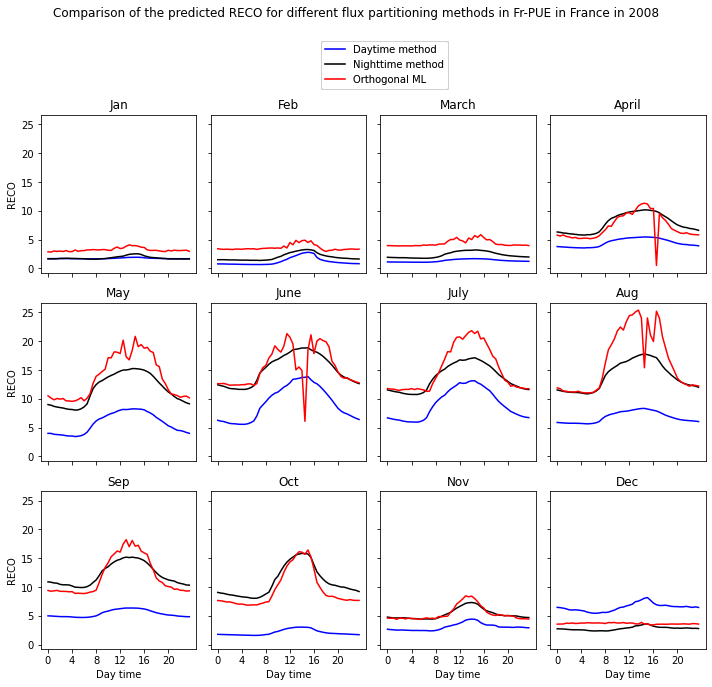

In [121]:
fig, axes = plt.subplots(3,4, figsize=(10,10), sharex=True, sharey=True)
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]


for month, ax in enumerate(axes.flatten()):
    df_temp = df[(df["Month"] == month+1) & (df["Year"] == 2008)]
    GPP_DT = df_temp.groupby("Time")["RECO_DT"].mean()
    GPP_NT = df_temp.groupby("Time")["RECO_NT"].mean()
    GPP_orth = df_temp.groupby("Time")["RECO_orth"].mean()
    GPP_GT = df_temp.groupby("Time")["RECO_syn"].mean()
    
    ax.plot(GPP_DT.values, color = "blue", label = "Daytime method")
    ax.plot(GPP_NT.values, color = "black", label = "Nighttime method")
    ax.plot(GPP_orth.values, color = "red", label = "Orthogonal ML")
    #ax.plot(GPP_GT.values, color = "yellow", label = "synthetic GT")
    handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, loc=(0.45, 0.87))
    
    ax.set_xticks(list(range(0,48,8)))
    ax.set_xticklabels(list(range(0,24,4)), fontsize = 10)
    if month // 4 == 2:
        ax.set_xlabel("Day time")
    if month % 4 == 0:
        ax.set_ylabel("RECO")
    ax.set_title(months[month])

fig.suptitle("Comparison of the predicted RECO for different flux partitioning methods in Fr-PUE in France in 2008")
fig.tight_layout(rect=[0, 0.03, 1, 0.90])
#fig.savefig("images/GPP2008.pdf", bbox_inches='tight')

## Postprocessing to use The Q10 DML

In [357]:
np.sum((RECO > 0)), np.sum((RECO <= 0))

(17159, 409)

In [358]:
df_1['RECO_orth'] = RECO
df_1l = df_1.loc[(df_1['RECO_orth'] > 0),:]
df_1l['RECO_orth_log'] = np.log(df_1l['RECO_orth'])
df_1l['TA_scaled'] = (df_1l['TA']-15)/10


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [359]:
df_2['RECO_orth'] = reco(X_2_normed, T_2, W_2_normed)
df_2l = df_2.loc[(df_2['RECO_orth'] > 0),:]
df_2l['RECO_orth_log'] = np.log(df_2l['RECO_orth'])
df_2l['TA_scaled'] = (df_2l['TA']-15)/10


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [360]:
#nn = FFPMLP12Regressor(model_fit_config, trainer_config, dataloader_config)
learner = GradientBoostingRegressor()
ml_g = clone(learner)
ml_m = clone(learner)
np.random.seed(1112)

obj_dml_data = dml.DoubleMLData(df_1l,  y_col='RECO_orth_log',
                                  d_cols='TA_scaled',
                                  x_cols=['SW_POT_sm_normed', 'SW_POT_sm_diff_normed'],
                                  use_other_treat_as_covariate=False)

dml_plr_obj = dml.DoubleMLPLR(obj_dml_data, ml_g, ml_m, dml_procedure='dml1', n_folds=10)
 #score = 'IV-type',
print(dml_plr_obj.fit())
print(np.exp(dml_plr_obj.coef))

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: RECO_orth_log
Treatment variable(s): ['TA_scaled']
Covariates: ['SW_POT_sm_normed', 'SW_POT_sm_diff_normed']
Instrument variable(s): None
No. Observations: 17159

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml1

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor()
Learner ml_m: GradientBoostingRegressor()

------------------ Resampling        ------------------
No. folds: 10
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
               coef   std err          t          P>|t|     2.5 %    97.5 %
TA_scaled  0.325178  0.008979  36.215082  3.524739e-287  0.307579  0.342777
[1.38427685]


In [368]:
Q10 = np.exp(dml_plr_obj.coef)
df["Rb"] = df["RECO_orth"]/Q10**(df['TA']-15)/10
df["RUE"] = -est.const_marginal_effect(X_normed)

In [373]:
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

In [388]:
data = df[['VPD', 'wdefCum', "RUE"]]
ncut = 40
cuts = pd.DataFrame({str(feature) : pd.cut(data[feature], ncut) for feature in ["VPD", "wdefCum"]})
means1 = data[['RUE']].join(cuts).groupby( list(cuts) ).mean()
means1 = means1.unstack(level = 0)

data = df[['GPP_orth', 'wdefCum', "Rb"]]
ncut = 40
cuts = pd.DataFrame({str(feature) : pd.cut(data[feature], ncut) for feature in ["GPP_orth", "wdefCum"]})
means2 = data[['Rb']].join(cuts).groupby( list(cuts) ).mean()
means2 = means2.unstack(level = 0)

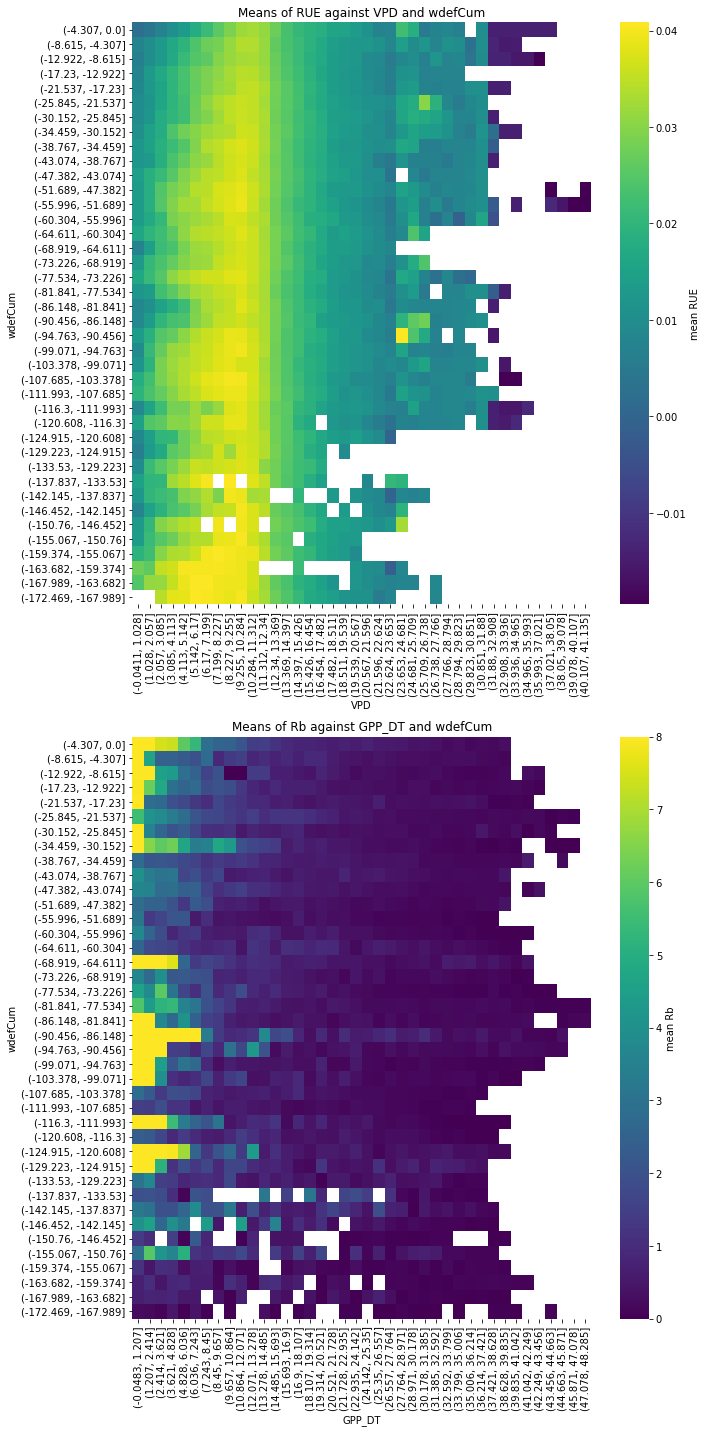

In [387]:
fig, ax = plt.subplots(2,1, figsize = (10,20), sharey=True)
sns.heatmap(means1['RUE'], ax=ax[0], cmap = "viridis", cbar_kws={'label': 'mean RUE'}) 
ax[0].set_title("Means of RUE against VPD and wdefCum")
ax[0].invert_yaxis()


sns.heatmap(means2['Rb'], ax=ax[1], cmap = "viridis", vmin=0, vmax=8, cbar_kws={'label': 'mean Rb'}) 
ax[1].set_title("Means of Rb against GPP_DT and wdefCum")
ax[1].invert_yaxis()

fig.tight_layout()
#fig.savefig("images/Heatmap.pdf", bbox_inches='tight')


In [376]:
df["RECO_orth"] = est.const_marginal_effect(X_normed)*T
#df["RECO_orth"] = df["NEE"] + df["GPP_orth"]
df["GPP_orth"] = df["NEE"]-df["RECO_orth"]
r2_score(df['RECO_DT'], df["RECO_orth"]), r2_score(df['RECO_NT'], df["RECO_orth"]), r2_score(df['GPP_DT'], df["GPP_orth"]), r2_score(df['GPP_NT'], df["GPP_orth"])

In [179]:
def smoothed(x, w):
    y = np.zeros(x.shape)
    for i in range(x.shape[0]):
        y[i] = x.iloc[max(-w+i,0):w+i].mean()
    return y

In [140]:
npdf_temp["RECO_orth"]

Series([], Name: RECO_orth, dtype: float64)

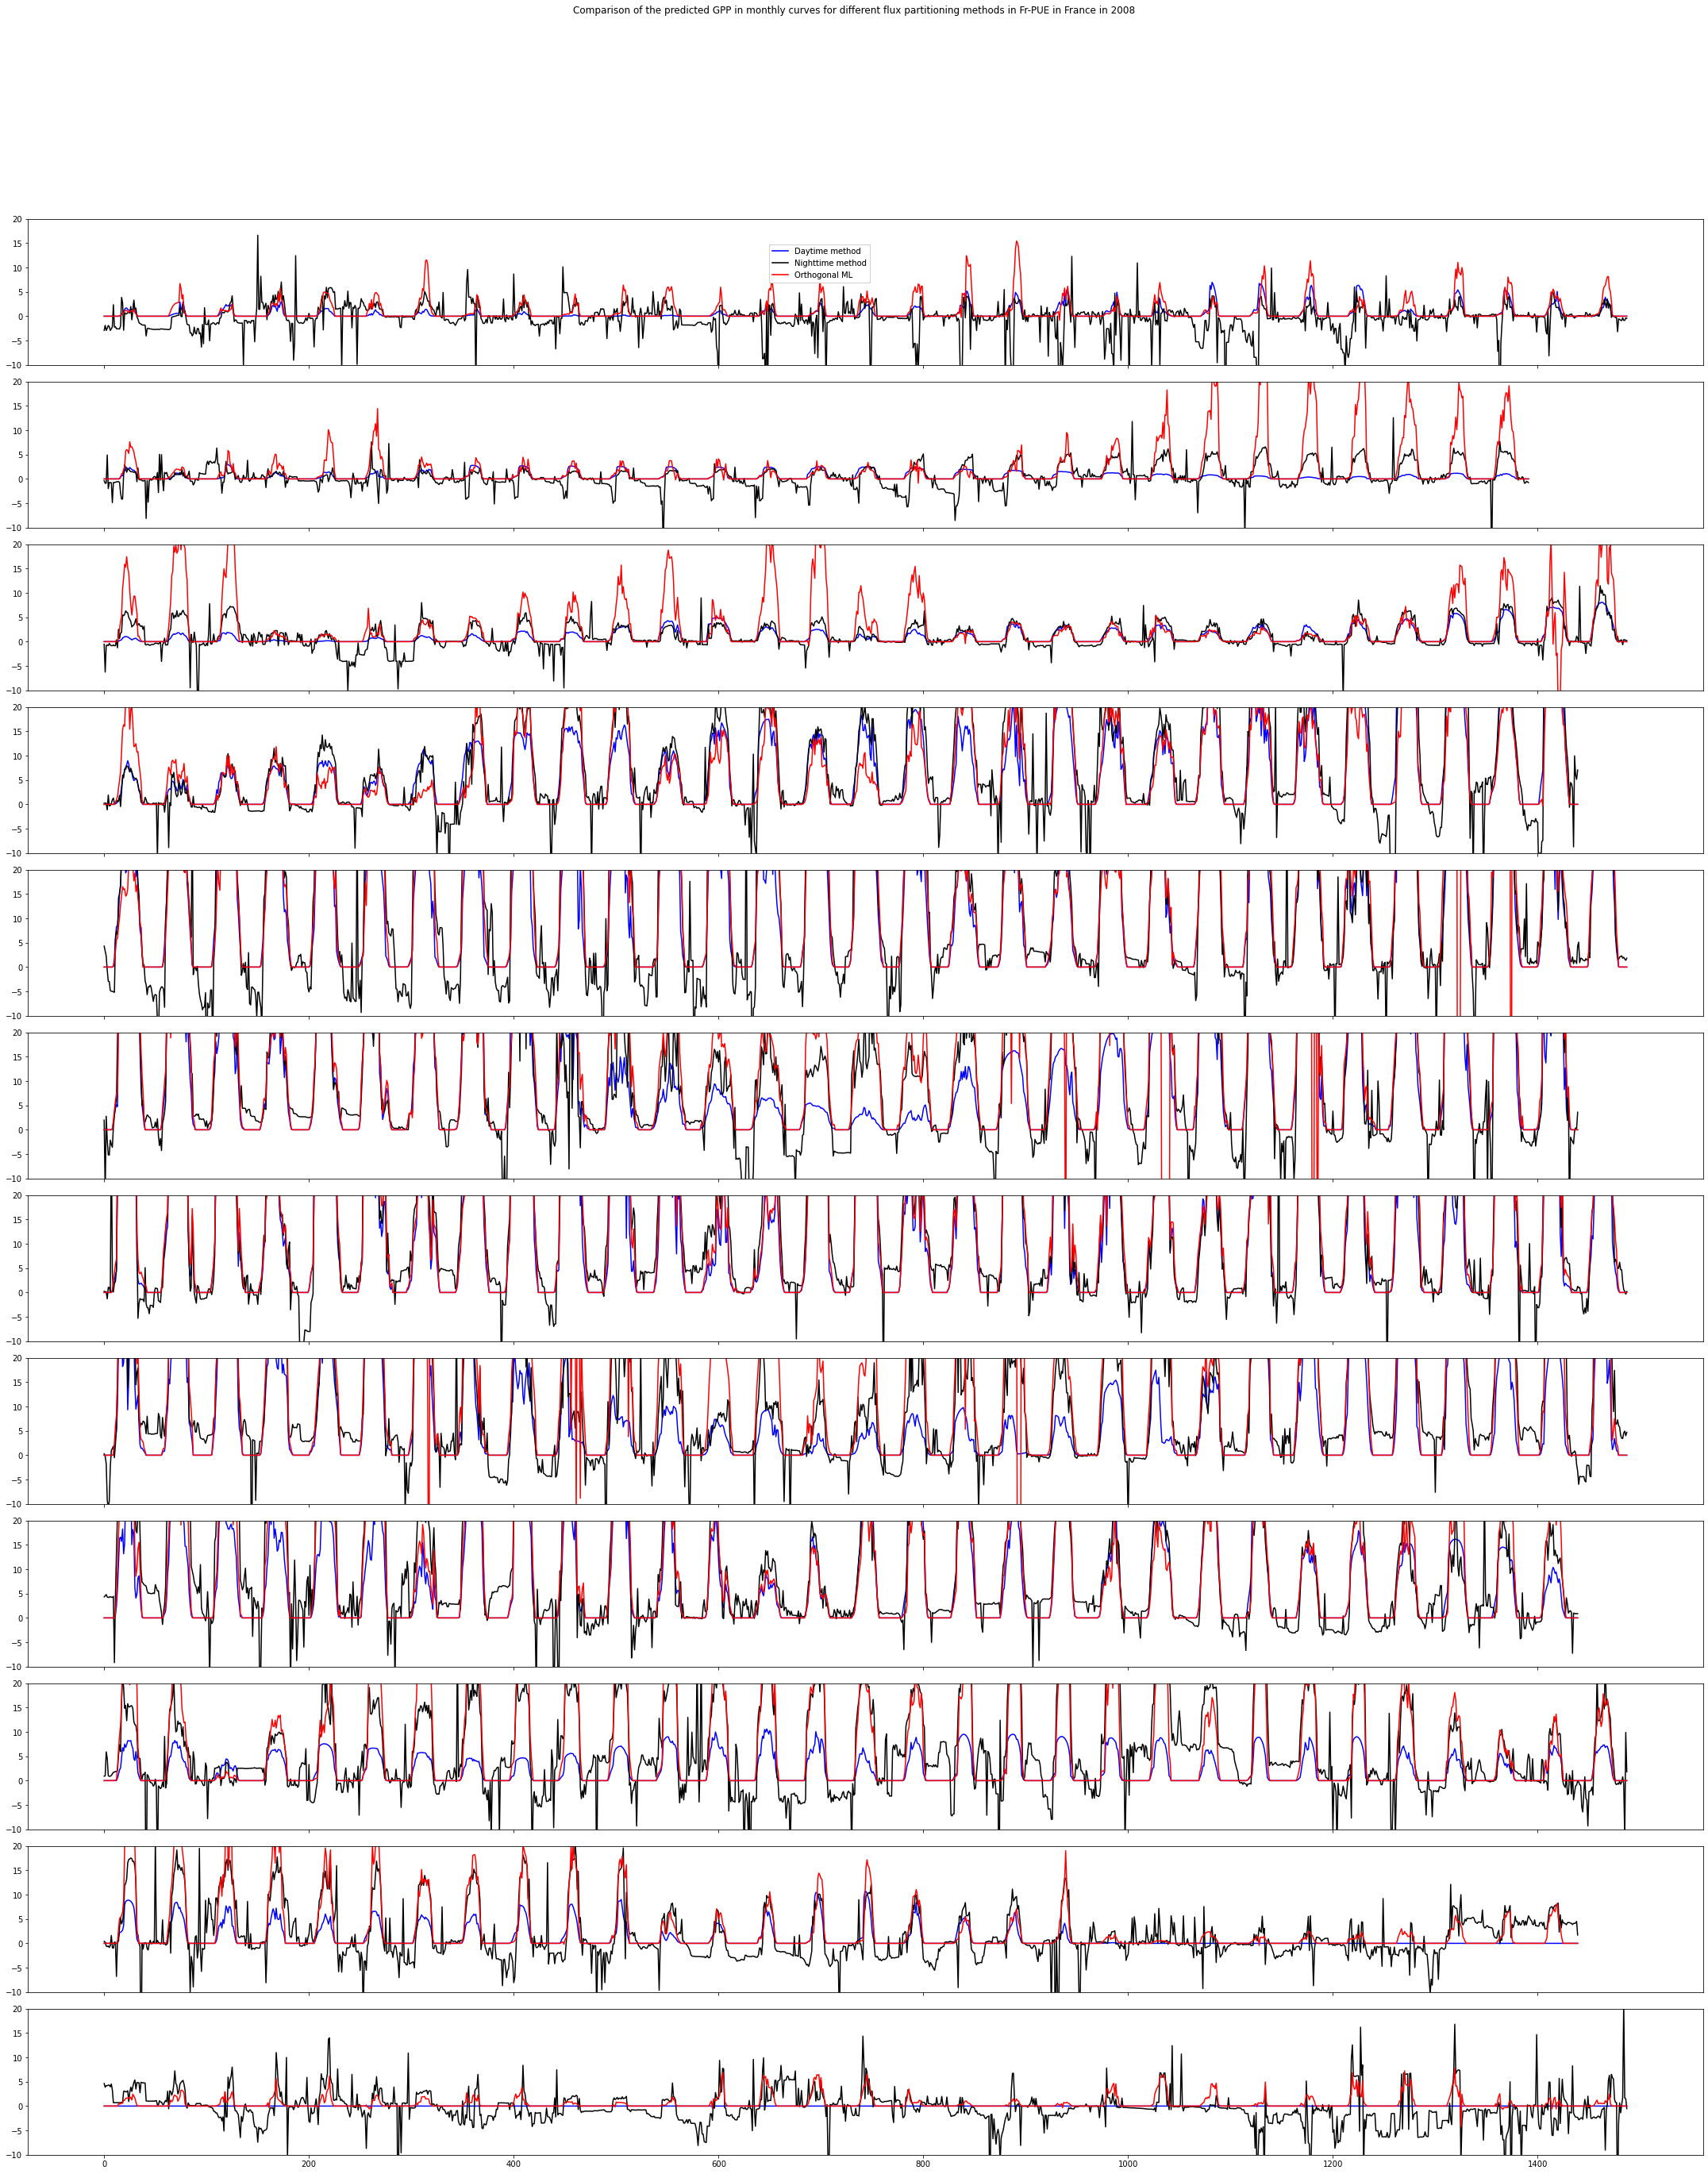

In [89]:
fig, axes = plt.subplots(12,1, figsize=(30,40), sharex=True, sharey=True)
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]


for month, ax in enumerate(axes.flatten()):
    df_temp = df[(df["Month"] == month+1) & (df["Year"] == 2008)]
    GPP_DT = df_temp["GPP_DT"]
    GPP_NT = df_temp["GPP_NT"]
    GPP_orth = df_temp["GPP_orth"]
    GPP_GT = df_temp["GPP_syn"]
    
    ax.plot(GPP_DT.values, color = "blue", label = "Daytime method")
    ax.plot(GPP_NT.values, color = "black", label = "Nighttime method")
    ax.plot(GPP_orth.values, color = "red", label = "Orthogonal ML")
    #ax.plot(GPP_GT.values, color = "yellow", label = "synthetic GT")
    
    #ax.plot(RECO_orth_def.values, color = "orange", label = "Orthogonal ML, deflated data")
    #ax.plot(RECO_orth_sm, color = "green", label = "Orthogonal ML smoothed")    
    handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, loc=(0.45, 0.87))
    ax.set_ylim((-10, 20))
    
    #ax.set_xticks(list(range(0,48,8)))
    #ax.set_xticklabels(list(range(0,24,4)), fontsize = 10)
    #if month // 4 == 2:
    #    ax.set_xlabel("Day time")
    #if month % 4 == 0:
    #    ax.set_ylabel("RECO")
    #ax.set_title(months[month])
    
fig.suptitle("Comparison of the predicted GPP in monthly curves for different flux partitioning methods in Fr-PUE in France in 2008")
fig.tight_layout(rect=[0, 0.03, 1, 0.90])
#fig.savefig("images/RECO2009.pdf", bbox_inches='tight')    

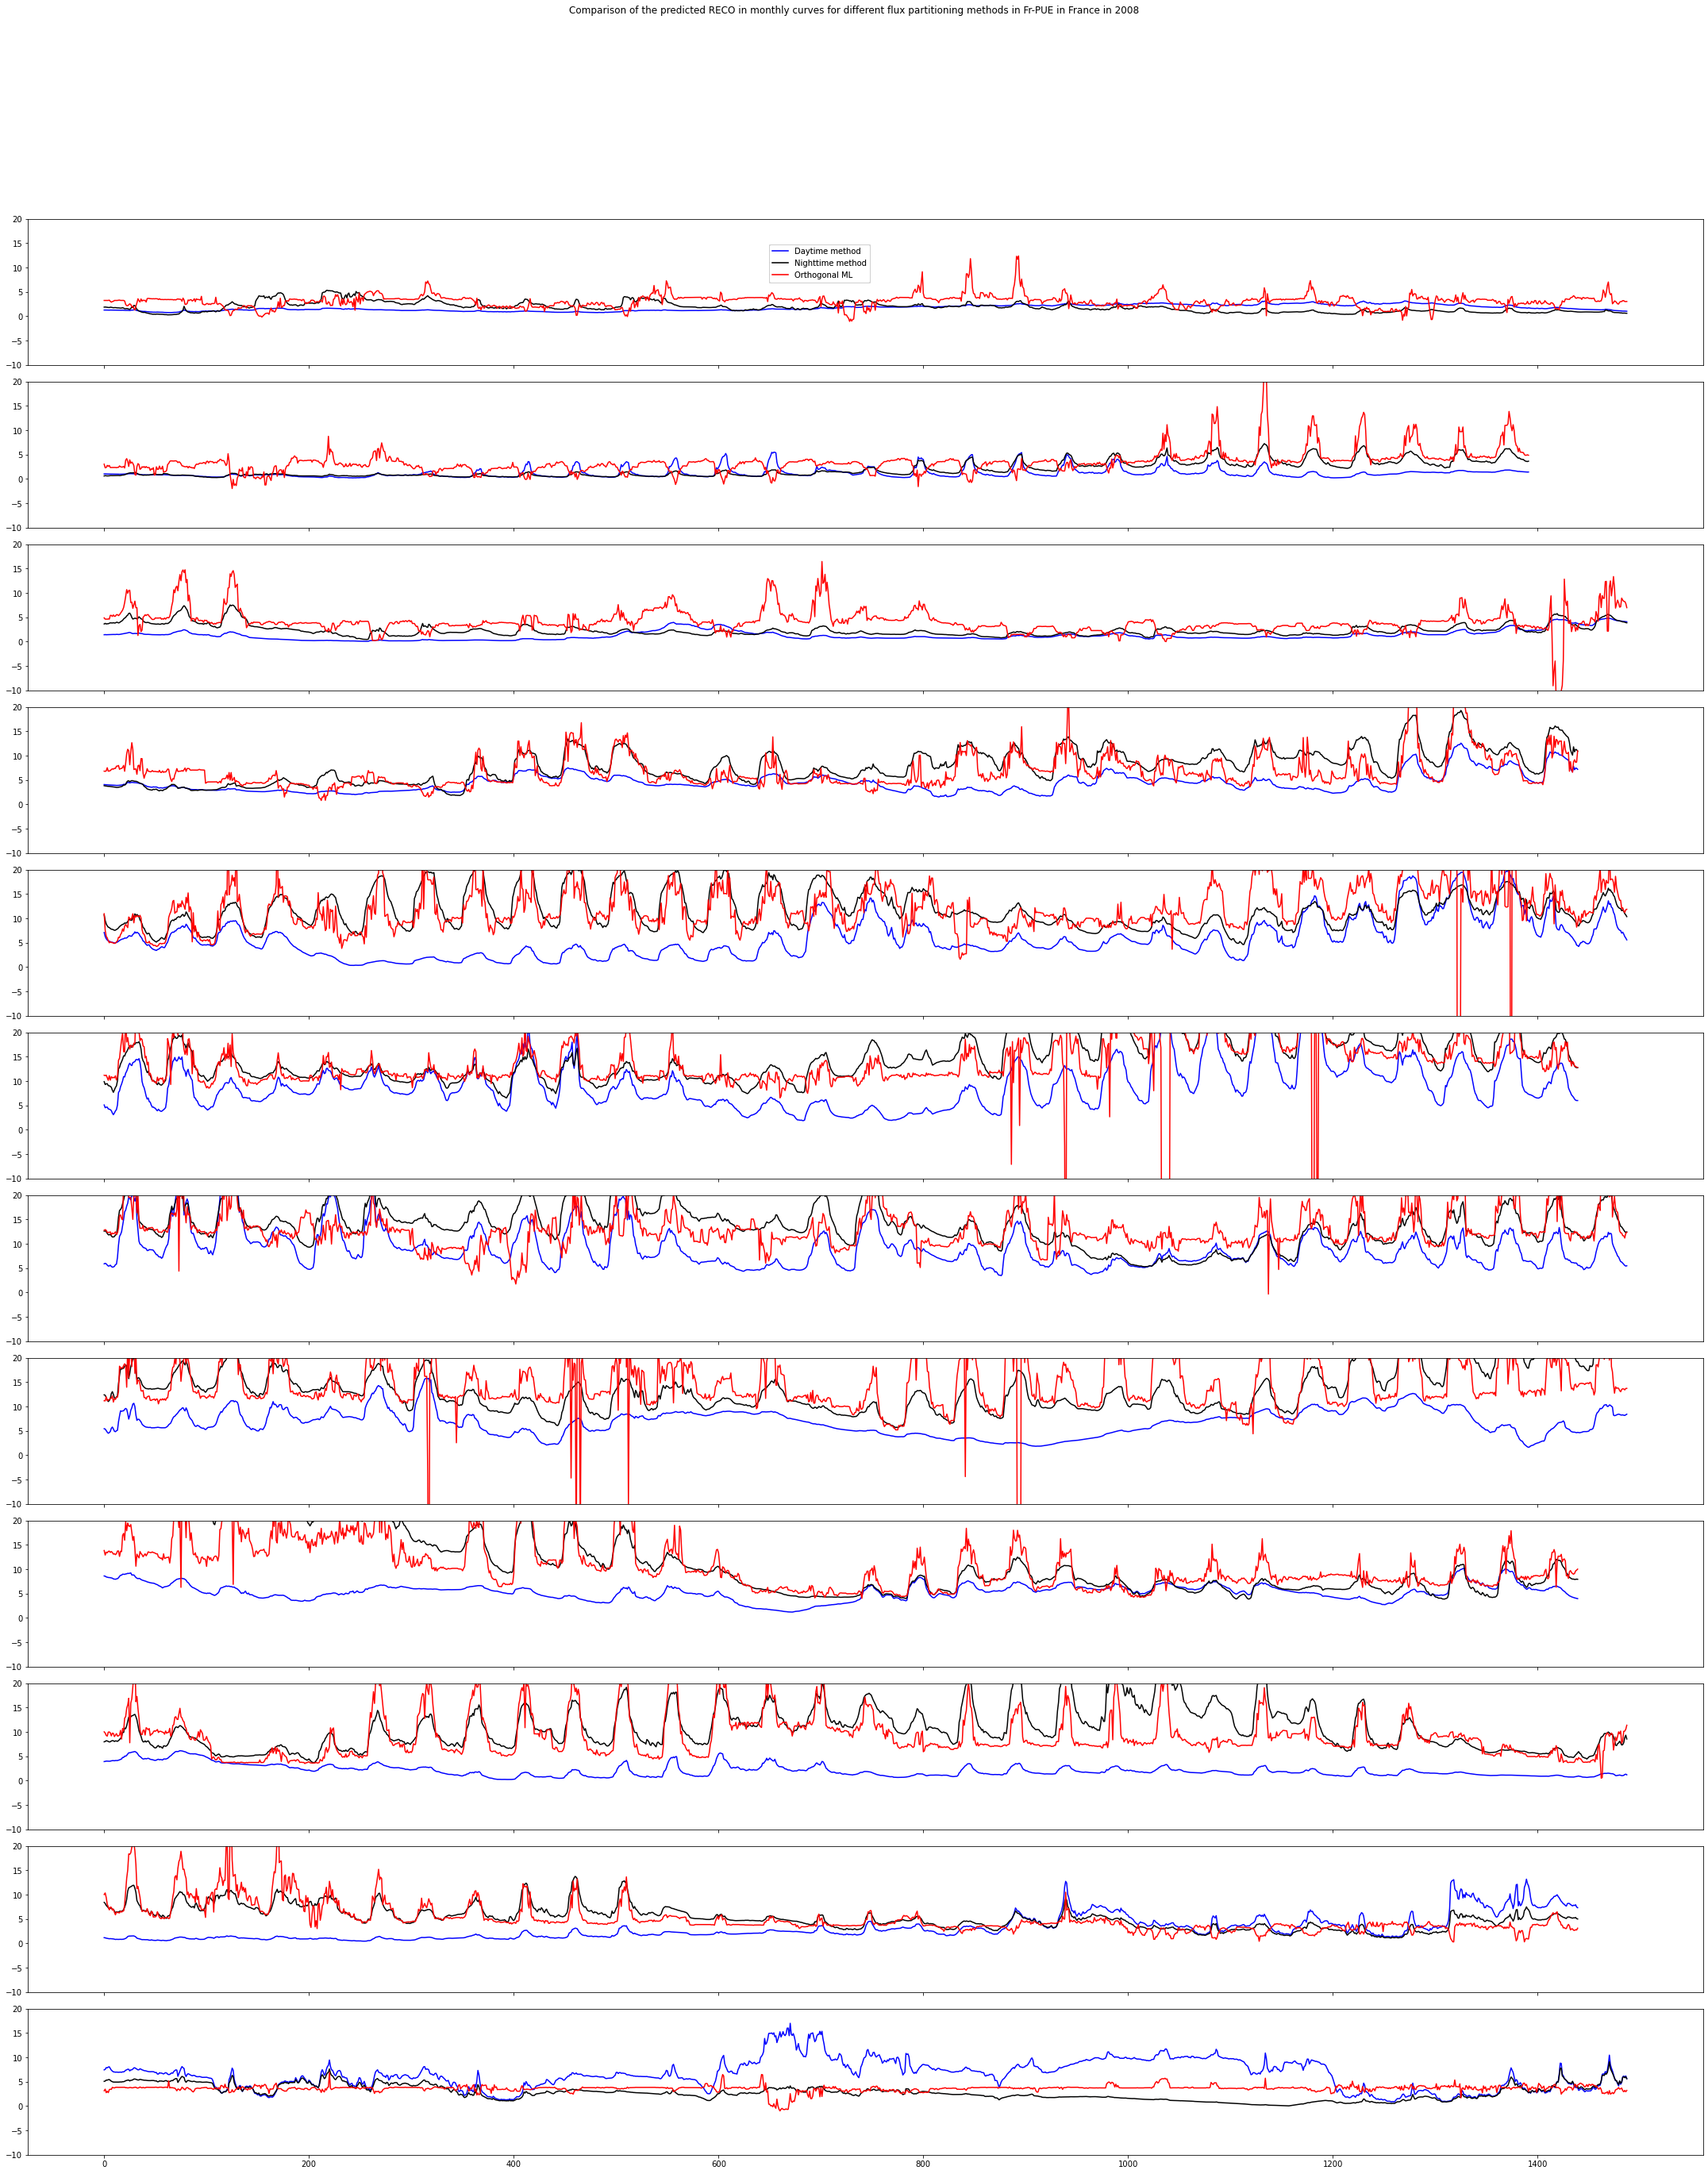

In [90]:
fig, axes = plt.subplots(12,1, figsize=(30,40), sharex=True, sharey=True)
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]


for month, ax in enumerate(axes.flatten()):
    df_temp = df[(df["Month"] == month+1) & (df["Year"] == 2008)]
    RECO_DT = df_temp["RECO_DT"]
    RECO_NT = df_temp["RECO_NT"]
    RECO_orth = df_temp["RECO_orth"]
    RECO_GT = df_temp["RECO_syn"]
    
    ax.plot(RECO_DT.values, color = "blue", label = "Daytime method")
    ax.plot(RECO_NT.values, color = "black", label = "Nighttime method")
    ax.plot(RECO_orth.values, color = "red", label = "Orthogonal ML")
    #ax.plot(RECO_GT.values, color = "yellow", label = "synthetic GT")
    
    #ax.plot(RECO_orth_def.values, color = "orange", label = "Orthogonal ML, deflated data")
    #ax.plot(RECO_orth_sm, color = "green", label = "Orthogonal ML smoothed")    
    handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, loc=(0.45, 0.87))
    ax.set_ylim((-10, 20))
    
    #ax.set_xticks(list(range(0,48,8)))
    #ax.set_xticklabels(list(range(0,24,4)), fontsize = 10)
    #if month // 4 == 2:
    #    ax.set_xlabel("Day time")
    #if month % 4 == 0:
    #    ax.set_ylabel("RECO")
    #ax.set_title(months[month])
    
fig.suptitle("Comparison of the predicted RECO in monthly curves for different flux partitioning methods in Fr-PUE in France in 2008")
fig.tight_layout(rect=[0, 0.03, 1, 0.90])
#fig.savefig("images/RECO2009.pdf", bbox_inches='tight')    